In [ ]:
!uv pip install metpy==1.6.3

Audited 1 package in 5ms


In [2]:
import xarray as xr
import metpy
import numpy as np
# Add colorbar with same height as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import requests
from typing import Optional, Union, Literal
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
from scipy.ndimage import gaussian_filter
import requests
import matplotlib.colors as mcolors
from itertools import product

# added by amy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.lines import Line2D



In [3]:
def pull_lsr_data(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. A "date" for LSRs is considered the
    date starting at 12 UTC to the next day at 11:59 UTC.
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """
    # Try the filtered URL first, if it fails, try without _filtered
    url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts_filtered.csv"
    # Check if the URL exists by attempting to open it
    response = requests.head(url)
    if date < pd.Timestamp('2004-02-29'):
        raise ValueError("LSR data before 2004-02-29 is not available in CSV format")
    if response.status_code == 404:
        # If the filtered URL doesn't exist, use the non-filtered version
        url = f"https://www.spc.noaa.gov/climo/reports/{date.strftime('%y%m%d')}_rpts.csv"
    # Read the CSV file with all columns to identify report types
    try:
        df = pd.read_csv(url, delimiter=',', engine='python', names=['Time','Scale','Location','County','State','Lat','Lon','Comments'])
    except Exception as e:
        print(f'Error pulling LSR data for {date}: {e}')
        return pd.DataFrame()
    if len(df) == 3:
        return pd.DataFrame()
    # Initialize report_type column
    df['report_type'] = None
    
    # Find rows with headers and mark subsequent rows with appropriate report type
    for i, row in df.iterrows():
        if 'F_Scale' in row.values:
            df.loc[i+1:, 'report_type'] = 'tor'
        elif 'Speed' in row.values:
            df.loc[i+1:, 'report_type'] = 'wind'
        elif 'Size' in row.values:
            df.loc[i+1:, 'report_type'] = 'hail'
    
    # Keep only necessary columns
    df = df[['Lat', 'Lon', 'report_type','Time', "Scale"]]
    # Remove rows that have 'Lat' in the 'Lat' column (these are header rows)
    df = df[df['Lat'] != 'Lat']
    time = pd.to_datetime(df['Time'], format='%H%M').dt.time
    df['Time'] = pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + time.astype(str))
    df = df.rename(columns={'Lat': 'lat', 'Lon': 'lon','Time':'time'})
    return df

In [4]:
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),)

In [5]:
date = pd.Timestamp(2023,3,31,18,00)

# Craven SigSvr Code:

In [5]:
def _wrap_metpy_mixed_layer_cape_cin(pressure, temperature, dewpoint):
    cape, cin = metpy.calc.thermo.mixed_layer_cape_cin(
        pressure * metpy.units.units.hPa,
        (temperature - 273.15) * metpy.units.units.degC,
        dewpoint * metpy.units.units.degC,
    )
    return cape.m, cin.m

# Craven, J. P., and H. E. Brooks, 2004: Baseline climatology
# of sounding derived parameters associated with deep moist convection. Natl. Wea. Digest, 28, 13-24.
def craven_sigsvr(ds: xr.Dataset) -> xr.DataArray:
    """Compute the Craven Significant Severe Parameter. Values over ~22,500 m3/s3 indicate higher
    likelihood of severe convection, hail, and tornadoes.
    Args:
        ds: An xarray Dataset containing winds, temperature, and humidity (relative and/or specific).

    Returns:
        sigsvr: An xarray DataArray containing the Craven Significant Severe Parameter in m3/s3.
    """
    # Compute estimated 0-6 km shear from Lepore et al 2021
    shear_0_6_km = np.sqrt(
        (ds["eastward_wind"].sel(level=500) - ds["surface_eastward_wind"]) ** 2
        + (ds["northward_wind"].sel(level=500) - ds["surface_northward_wind"]) ** 2
    )
    pressure_levels = ds.isel(level=slice(None, None, -1)).assign(pressure=lambda x: x['level'])['pressure']
    
    temperature = ds["air_temperature"]

    if "dewpoint_temperature" in ds.variables:
        dewpoint_temperature = (
            ds["dewpoint_temperature"]
        )
    else:
        raise ValueError("No humidity variable found in dataset")
    # Make sure all inputs have the same level coordinate by selecting with pressure_levels
    mlcape, _ = xr.apply_ufunc(
        _wrap_metpy_mixed_layer_cape_cin,
        pressure_levels,
        temperature.sel(level=pressure_levels),
        dewpoint_temperature.sel(level=pressure_levels),
        input_core_dims=[["level"], ["level"], ["level"]],
        output_core_dims=[[], []],
        vectorize=True,
        output_dtypes=[float, float],
    )
    sigsvr = mlcape * shear_0_6_km
    return sigsvr


# Practically Perfect Code:

In [6]:
def practically_perfect_hindcast(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = pull_lsr_data(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Extract latitude and longitude from the dataframe
    lats = df["lat"].astype(float)
    lons = df["lon"].astype(float)

    # Create a grid covering the continental US (or adjust as needed)
    lat_min, lat_max = 24.0, 50.0  # Continental US approximate bounds
    lon_min, lon_max = -125.0, -66.0  # Continental US approximate bounds

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # Mark grid cells that contain reports
    for lat, lon in zip(lats, lons):
        # Find the nearest grid indices
        lat_idx = np.abs(grid_lats - lat).argmin()
        lon_idx = np.abs(grid_lons - lon).argmin()
        grid[lat_idx, lon_idx] = 1

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
    if return_reports:
        return (pph, df)
    return pph

In [20]:
def plot_map(pph, df, title,ax_return=False):
    """Temporary helper function to plot some of the forthcoming maps."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS)

    # Plot the data using contourf
    levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1

    # Create a custom colormap that sets alpha=0 for values below 0.05
    cmap = plt.cm.viridis
    norm = mcolors.BoundaryNorm(levels, cmap.N)

    # Create a mask for values below 0.05
    mask = np.ma.masked_less(pph, 0.05)

    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.viridis.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

    contour = ax.contourf(pph.longitude, pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        cmap=cmap_with_alpha, extend='both')

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Probability')
    # Plot the individual reports from the dataframe
    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    # Create a color map for different report types
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}
    
    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['lon'].astype(float), group['lat'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))

    # # Set the extent to focus on the continental US
    # ax.set_extent([pph.longitude.min(), pph.longitude.max(), 
    #                pph.latitude.min(), pph.latitude.max()], 
    #               crs=ccrs.PlateCarree())

    # Add a legend
    ax.legend(loc='upper right')
    if ax_return:
        return ax
    plt.title(title)
    plt.tight_layout()
    plt.show()

# PPH Plotting and Grid Comparisons:

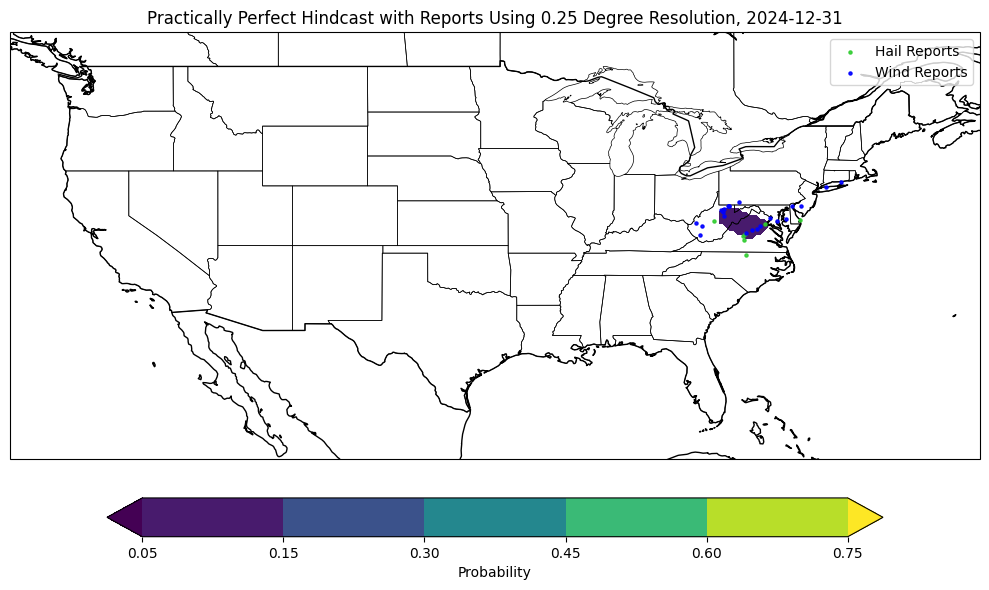

In [25]:
pph, df = practically_perfect_hindcast(date, sigma=5, return_reports=True,output_resolution=0.25)
# Create a figure with a map projection
plot_map(pph, df, f'Practically Perfect Hindcast with Reports Using 0.25 Degree Resolution, {date.strftime("%Y-%m-%d")}')

The cells below won't work unless you download and access pper_all_svr_1979_2023.nc locally

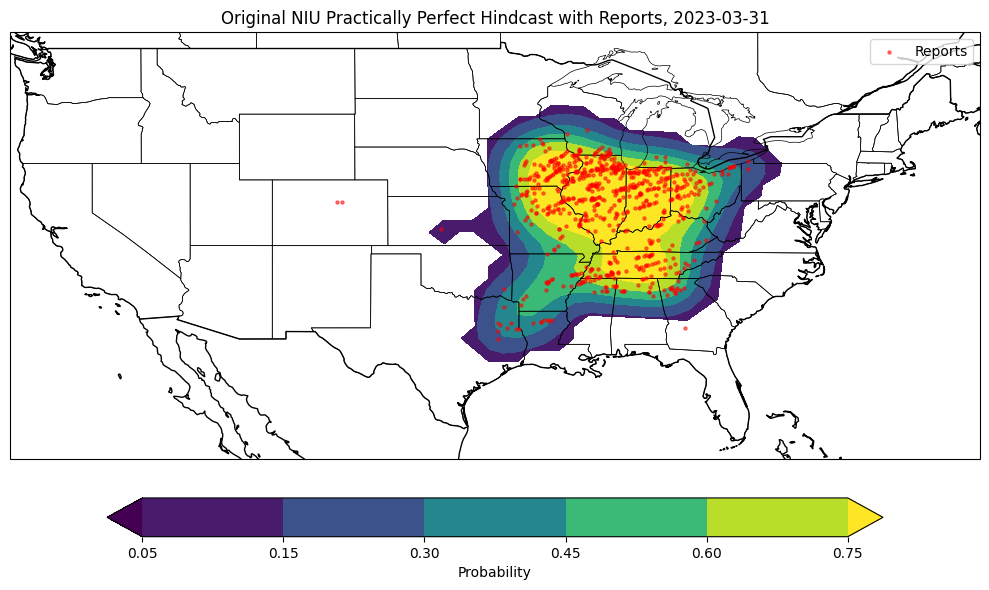

In [17]:
# This will break as this is local data
pph_orig = xr.open_dataset('/home/taylor/data/pper_all_svr_1979_2023.nc')

# Create a new dataset with latitude and longitude as dimensions
# First, select a time slice to work with
pph_orig = pph_orig.sel(time=date, method='nearest')
# pph_orig = pph_orig.swap_dims({'x':'lon', 'y':'lat'})

# pph_orig = pph_orig.interp_like(outbreak)
# Create a figure with a map projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS)

# Plot the data using contourf
levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1

# Create a custom colormap that sets alpha=0 for values below 0.05
cmap = plt.cm.viridis
norm = mcolors.BoundaryNorm(levels, cmap.N)

# Create a mask for values below 0.05
mask = np.ma.masked_less(pph_orig['p_perfect_totalsvr']/100, 0.05)

# Create the colormap with alpha=0 for values below 0.05
cmap_with_alpha = plt.cm.viridis.copy()
cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

contour = ax.contourf(pph_orig.lon, pph_orig.lat, mask, 
                     levels=levels, transform=ccrs.PlateCarree(),
                     cmap=cmap_with_alpha, extend='both')

# Add colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Probability')
# Plot the individual reports from the dataframe
# Make sure reports are visible by increasing size and using a distinctive color
# Convert string coordinates to float before plotting
scatter = ax.scatter(df['lon'].astype(float), df['lat'].astype(float), 
                    color='red', s=20, marker='.', alpha=0.5,
                    transform=ccrs.PlateCarree(), label='Reports', zorder=10)

# # Set the extent to focus on the continental US
ax.set_extent([pph.longitude.min(), pph.longitude.max(), 
               pph.latitude.min(), pph.latitude.max()], 
              crs=ccrs.PlateCarree())

# Add a legend
ax.legend(loc='upper right')

plt.title(f'Original NIU Practically Perfect Hindcast with Reports, {date.strftime("%Y-%m-%d")}')
plt.tight_layout()
plt.show()

## Regridded Eta NCEP 212 to ERA5 .25 Gaussian:

In [26]:
# Extract HRRR variable and coordinates
var = pph_orig['p_perfect_totalsvr']
lon2d = pph_orig['lon'].values
lat2d = pph_orig['lat'].values

# Flatten the HRRR grid
points = np.column_stack((lon2d.ravel(), lat2d.ravel()))
values = var.values.ravel()

# ERA5 grid
target_lon, target_lat = np.meshgrid(pph.longitude.values, pph.latitude.values)
target_points = (target_lon, target_lat)

# Interpolate
regridded = griddata(points, values, (target_lon, target_lat), method='linear')

# Save or wrap into an xarray DataArray
pph_orig_regridded = xr.DataArray(
    regridded,
    dims=("latitude", "longitude"),
    coords={"latitude": pph.latitude, "longitude": pph.longitude},
    name="p_perfect_totalsvr"
)
pph_orig_regridded_longitude_360 = (pph_orig_regridded.longitude + 360) % 360
# pph_orig = pph_orig.interp_like(outbreak)
# Create a figure with a map projection
plot_map(pph_orig_regridded/100, df, f'Original NIU Practically Perfect Hindcast with Reports, Regridded to 0.25 Degree Resolution, {date.strftime("%Y-%m-%d")}')

NameError: name 'pph_orig' is not defined

## Comparing Shape Similarity Using SSIM:
Using MSE did not provide a similar shape

In [19]:
!uv pip install scikit-image

Resolved 9 packages in 121ms                                         
Prepared 1 package in 40ms                                               
Installed 5 packages in 29ms                                
 + imageio==2.37.0
 + lazy-loader==0.4
 + networkx==3.4.2
 + scikit-image==0.25.2
 + tifffile==2025.5.10


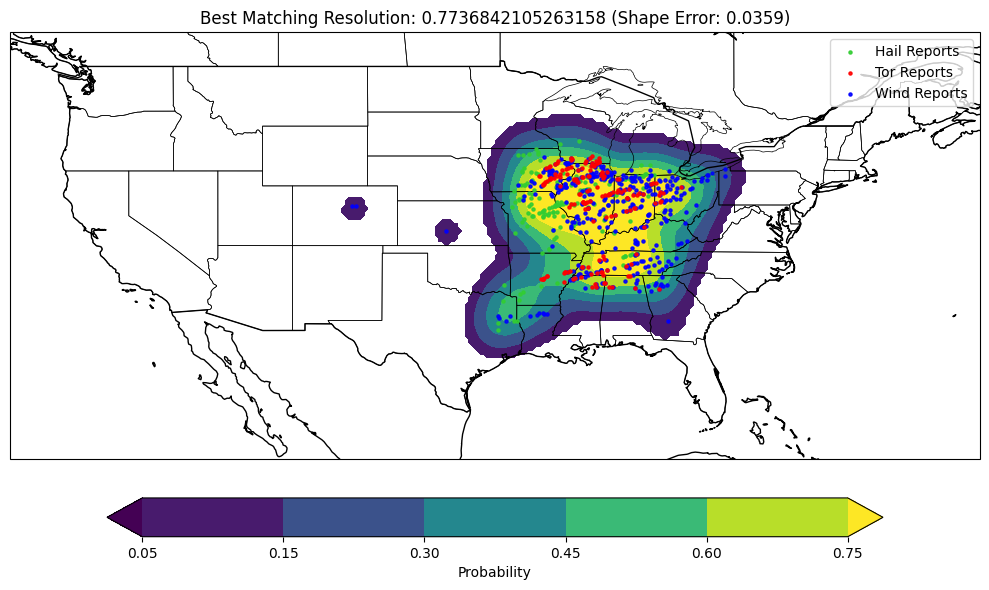

Best matching resolution: 0.7736842105263158 (Shape Error: 0.0359)


In [22]:
resolution_values = np.linspace(0.7, 0.9, 20)
best_score = float('inf')
best_res = None
best_pph = None
# Compute structural similarity index (SSIM) which better captures shape differences
# SSIM ranges from -1 to 1, with 1 being perfect match, so we use 1-SSIM as error
from skimage.metrics import structural_similarity as ssim
for res in resolution_values:
    # Generate PPH with the current resolution, interpolate to target grid
    test_pph = practically_perfect_hindcast(
        date, 
        resolution=res, 
        output_resolution=0.25  # match target grid spacing
    )
    target = pph_orig_regridded
    

    # Normalize data for SSIM calculation
    test_norm = (test_pph.values - np.nanmin(test_pph.values)) / (np.nanmax(test_pph.values) - np.nanmin(test_pph.values))
    target_norm = (target.values - np.nanmin(target.values)) / (np.nanmax(target.values) - np.nanmin(target.values))
    
    # Replace NaNs with zeros for SSIM calculation
    test_norm = np.nan_to_num(test_norm)
    target_norm = np.nan_to_num(target_norm)
    
    ssim_value = ssim(test_norm, target_norm, data_range=1.0)
    error = 1 - ssim_value  # Convert to error metric (lower is better)
    if error < best_score:
        best_score = error
        best_res = res
        best_pph = test_pph

plot_map(best_pph, df, f'Best Matching Resolution: {best_res} (Shape Error: {best_score:.4f})')

print(f"Best matching resolution: {best_res} (Shape Error: {best_score:.4f})")

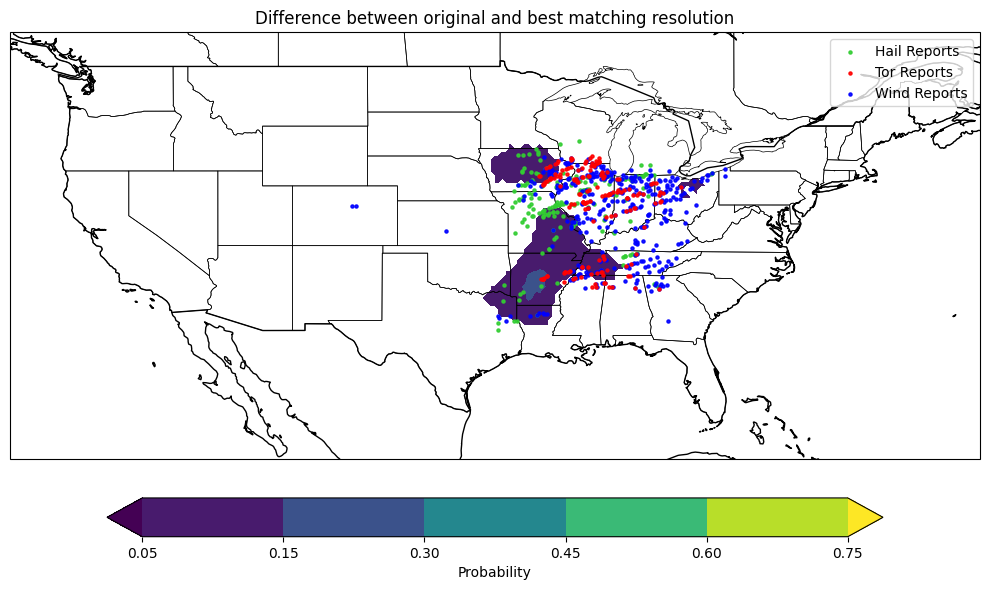

In [21]:
plot_map(pph_orig_regridded/100 - best_pph, df, 'Difference between original and best matching resolution')

# Comparing SigSvr to PPH:

In [23]:
# Convert longitude from -180/180 to 0-360 format
pph_orig_regridded_longitude_360 = (pph_orig_regridded.longitude + 360) % 360

## Aggregate ERA5 Max Craven

In [23]:
date = pd.Timestamp(2023,3,31,18,00)

date_range = pd.date_range('2023-03-30 18:00','2023-04-01 06:00', freq='6h')
craven_vals = []
from tqdm.notebook import tqdm
for date in tqdm(date_range):
    outbreak = era5.sel(time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
    outbreak = outbreak.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                                '10m_v_component_of_wind': 'surface_northward_wind',
                                'u_component_of_wind': 'eastward_wind',
                                'v_component_of_wind': 'northward_wind',
                                'temperature': 'air_temperature',
                                })
    outbreak = outbreak[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
    outbreak = outbreak.compute()
    outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(outbreak['level'] * metpy.units.units.hPa, outbreak['specific_humidity'] * metpy.units.units.dimensionless)
    craven_vals.append(craven_sigsvr(outbreak))
max_era5_craven = xr.concat(craven_vals,dim='time').max(dim='time')

  0%|          | 0/7 [00:00<?, ?it/s]

# Outputting CSS for MLWP + ERA5:

## Only ERA5, single timestep:

In [78]:
era5_test = era5.sel(time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
era5_test = era5_test.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                            '10m_v_component_of_wind': 'surface_northward_wind',
                            'u_component_of_wind': 'eastward_wind',
                            'v_component_of_wind': 'northward_wind',
                            'temperature': 'air_temperature',
                            })
era5_test = era5_test[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
era5_test = era5_test.compute()
era5_test['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(era5_test['level'] * metpy.units.units.hPa, era5_test['specific_humidity'] * metpy.units.units.dimensionless)

era5_craven_test = craven_sigsvr(era5_test)

## Multiple timesteps:

In [65]:
craven_test = []

date_range = pd.date_range('2023-03-30 18:00','2023-04-01 06:00', freq='6h')
for d in date_range:
    outbreak = era5.sel(time=d,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
    outbreak = outbreak.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                                '10m_v_component_of_wind': 'surface_northward_wind',
                                'u_component_of_wind': 'eastward_wind',
                                'v_component_of_wind': 'northward_wind',
                                'temperature': 'air_temperature',
                                })
    outbreak = outbreak[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
    outbreak = outbreak.compute()
    outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(outbreak['level'] * metpy.units.units.hPa, outbreak['specific_humidity'] * metpy.units.units.dimensionless)
    craven_single = craven_sigsvr(outbreak)
    craven_test.append(craven_single)

craven_test_max = xr.concat(craven_test, dim='time').max(dim='time')

KeyboardInterrupt: 

In [17]:
from extremeweatherbench import data_loader, config

In [25]:
def safe_rename(ds, name_dict, return_renamed_only=False):
    """
    Safely rename variables in an xarray Dataset using a dictionary.
    Skips any keys that don't exist in the dataset.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset to rename variables in
    name_dict : dict
        Dictionary mapping old names to new names
    
    Returns:
    --------
    xarray.Dataset
        Dataset with renamed variables
    """
    # Create a new dictionary with only the keys that exist in the dataset
    valid_renames = {k: v for k, v in name_dict.items() if k in ds}
    
    # Only perform rename if there are valid keys
    if valid_renames:
        if return_renamed_only:
            ds = ds.rename(valid_renames)
            return ds[[v for k,v in valid_renames.items() if v in ds]]
        else:
            return ds.rename(valid_renames)
    else:
        if return_renamed_only:
            raise KeyError('None of the provided keys exist in the dataset')
        else:
            return ds


In [ ]:
for models in ['GRAP_v100_GFS']:
    if models == 'era5':
        outbreak = era5.sel(time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
    else:
        basic_config = config.Config(
            forecast_dir=f'gs://extremeweatherbench/{models}.parq',
            event_types=['Severe']
        )
        outbreak = data_loader.open_kerchunk_reference(basic_config)
        outbreak = safe_rename(outbreak,{'u10': 'surface_eastward_wind',
                                    'v10': 'surface_northward_wind',
                                    'u': 'eastward_wind',
                                    'v': 'northward_wind',
                                    't': 'air_temperature',
                                    'r': 'relative_humidity',
                                    'q': 'specific_humidity',
                                    },return_renamed_only=True)
        outbreak = outbreak.sel(init_time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
        outbreak = outbreak.compute()
        if 'relative_humidity' in outbreak:
            outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_relative_humidity(outbreak['air_temperature'] * metpy.units.units.degC, outbreak['relative_humidity'] * metpy.units.units.percent)
        else:
            outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(outbreak['level'] * metpy.units.units.hPa, outbreak['specific_humidity'] * metpy.units.units.dimensionless)
        # Inverse the level dimension to match ERA5
        outbreak = outbreak.sortby('level', ascending=True)
mlwp_craven_test = craven_sigsvr(outbreak.isel(time=0)) # Lead time 0 hrs

/home/taylor/code/ExtremeWeatherBench/.venv/lib/python3.11/site-packages/metpy/calc/thermo.py:1753: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


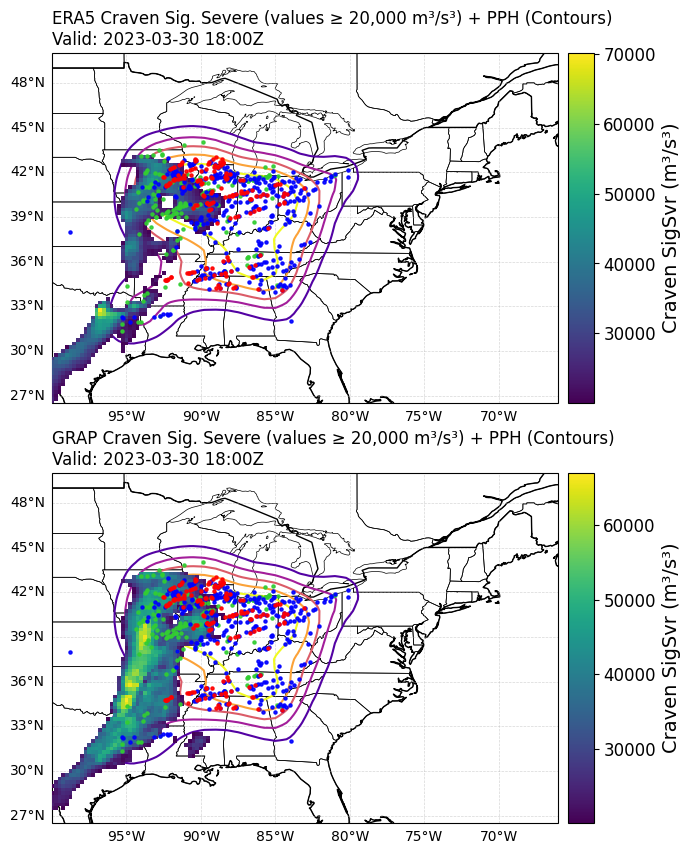

In [ ]:
# Create a figure with a map projection
fig = plt.figure(figsize=(10, 10))
# Fix the KeyError by explicitly creating a GeoAxes with projection
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
# Mask values below 5,000
masked_sigsvr = era5_craven_test.where(era5_craven_test >= 20000)
# Plot with aligned colorbar
im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                        add_colorbar=False,zorder=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
cbar.set_label("Craven SigSvr (m³/s³)", size=14)
cbar.ax.tick_params(labelsize=12)
# ax.set_title(f'ERA5 Craven Significant Severe Parameter (values ≥ 20,000 m³/s³) + PPH (Contours) \nValid: {date_range[0].strftime("%Y-%m-%d %H:%MZ")} - {date_range[-1].strftime("%Y-%m-%d %H:%MZ")}',loc='left')
ax.set_title(f'ERA5 Craven Sig. Severe (values ≥ 20,000 m³/s³) + PPH (Contours) \nValid: {date.strftime("%Y-%m-%d %H:%MZ")}',loc='left')
masked_sigsvr = mlwp_craven_test.where(mlwp_craven_test >= 20000)

im = masked_sigsvr.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='viridis',
                        add_colorbar=False,zorder=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
cbar.set_label("Craven SigSvr (m³/s³)", size=14)
cbar.ax.tick_params(labelsize=12)
ax2.set_title(f'GRAP Craven Sig. Severe (values ≥ 20,000 m³/s³) + PPH (Contours) \nValid: {date.strftime("%Y-%m-%d %H:%MZ")}',loc='left')

levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1
# Create a custom colormap that sets alpha=0 for values below 0.05
cmap = plt.cm.viridis
norm = mcolors.BoundaryNorm(levels, cmap.N)
# Create a mask for values below 0.05
mask = np.ma.masked_less(best_pph, 0.05)
for a in [ax,ax2]:
    # Add map features
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.STATES, linewidth=0.5)
    a.add_feature(cfeature.BORDERS)
    gl = a.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    a.set_title('')
    a.set_extent([mlwp_craven_test.longitude.min(), mlwp_craven_test.longitude.max(), 
                mlwp_craven_test.latitude.min(), mlwp_craven_test.latitude.max()], 
                crs=ccrs.PlateCarree())
    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.plasma.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

    contour = a.contour(best_pph.longitude, best_pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        cmap=cmap_with_alpha, extend='both')

    # Plot the individual reports from the dataframe
    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}
    
    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        a.scatter(group['lon'].astype(float), group['lat'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))


## Aggregate Timestep ERA5 and GRAP

In [ ]:
models = ['GRAP_v100_GFS']
outputs_aggregate = {}
date_range = pd.date_range('2023-03-30 18:00','2023-04-01 06:00', freq='6h')
for model, date in product(models,date_range):
    if model == 'era5':
        case = era5.sel(time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
        case = case.compute()
    else:
        basic_config = config.Config(
            forecast_dir=f'gs://extremeweatherbench/{model}.parq',
            event_types=['Severe']
        )

        model_ds = data_loader.open_kerchunk_reference(basic_config)
        model_ds = safe_rename(model_ds,{'u10': 'surface_eastward_wind',
                                    'v10': 'surface_northward_wind',
                                    'u': 'eastward_wind',
                                    'v': 'northward_wind',
                                    't': 'air_temperature',
                                    'r': 'relative_humidity',
                                    'q': 'specific_humidity',
                                    },return_renamed_only=True)

        case = model_ds.sel(init_time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
        case = case.compute()
        if 'relative_humidity' in case:
            case['dewpoint_temperature'] = metpy.calc.dewpoint_from_relative_humidity(case['air_temperature'] * metpy.units.units.degC, case['relative_humidity'] * metpy.units.units.percent)
        else:
            case['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(case['level'] * metpy.units.units.hPa, case['specific_humidity'] * metpy.units.units.dimensionless)
        # Inverse the level dimension to match ERA5
        case = case.sortby('level', ascending=True)
        case = case.isel(time=0) # select hour 0
    craven_single = craven_sigsvr(case)
    outputs_aggregate[model][date] = craven_single

max_grap_craven_multiple_timesteps = xr.concat([value for (time,value) in outputs_aggregate['GRAP_v100_GFS'].items()],dim='time').max(dim='time')


In [168]:
# Save max_grap_craven_multiple_timesteps to a pickle file
import pickle
import os

# Define the file path for GRAP data
grap_output_file = '/home/taylor/data/max_grap_craven_2023033018_2023040106.pkl'

# Only save if the file doesn't exist
if not os.path.exists(grap_output_file):
    # Save the data to a pickle file
    with open(grap_output_file, 'wb') as f:
        pickle.dump(max_grap_craven_multiple_timesteps, f)
    print(f"Saved max_grap_craven_multiple_timesteps to {grap_output_file}")
else:
    print(f"File {grap_output_file} already exists, skipping save")

# Define the file path for ERA5 data
era5_output_file = '/home/taylor/data/max_era5_craven_2023033018_2023040106.pkl'

# Only save if the file doesn't exist
if not os.path.exists(era5_output_file):
    # Save the data to a pickle file
    with open(era5_output_file, 'wb') as f:
        pickle.dump(max_era5_craven, f)
    print(f"Saved max_era5_craven to {era5_output_file}")
else:
    print(f"File {era5_output_file} already exists, skipping save")

Saved max_grap_craven_multiple_timesteps to /home/taylor/data/max_grap_craven_2023033018_2023040106.pkl
Saved max_era5_craven to /home/taylor/data/max_era5_craven_2023033018_2023040106.pkl


In [87]:
# Load max_era5_craven from the pickle file
with open('/home/taylor/data/max_era5_craven_2023033018_2023040106.pkl', 'rb') as f:
    max_era5_craven = pickle.load(f)

with open('/home/taylor/data/max_grap_craven_2023033018_2023040106.pkl', 'rb') as f:
    max_grap_craven_multiple_timesteps = pickle.load(f)


In [89]:
date_range = pd.date_range('2023-03-30 18:00','2023-04-01 06:00', freq='6h')

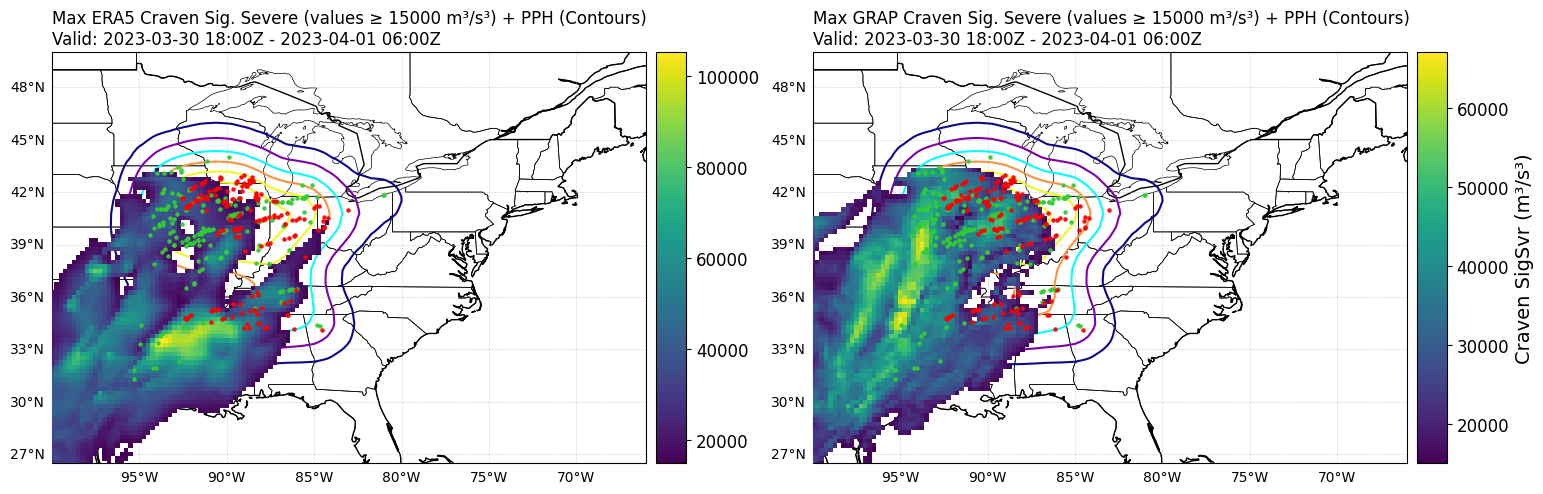

In [143]:
# Create a figure with a map projection
fig = plt.figure(figsize=(18, 10))
# Fix the KeyError by explicitly creating a GeoAxes with projection
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
# Mask values below 5,000
masked_sigsvr = max_era5_craven.where(max_era5_craven >= 15000)
# Plot with aligned colorbar
im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                        add_colorbar=False,zorder=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
cbar.set_label("")
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'Max ERA5 Craven Sig. Severe (values ≥ 15000 m³/s³) + PPH (Contours) \nValid: {date_range[0].strftime("%Y-%m-%d %H:%MZ")} - {date_range[-1].strftime("%Y-%m-%d %H:%MZ")}', loc='left')

masked_sigsvr = max_grap_craven_multiple_timesteps.where(max_grap_craven_multiple_timesteps >= 15000)

im = masked_sigsvr.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='viridis',
                        add_colorbar=False,zorder=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
cbar.set_label("Craven SigSvr (m³/s³)", size=14)
cbar.ax.tick_params(labelsize=12)
ax2.set_title(f'Max GRAP Craven Sig. Severe (values ≥ 15000 m³/s³) + PPH (Contours) \nValid: {date_range[0].strftime("%Y-%m-%d %H:%MZ")} - {date_range[-1].strftime("%Y-%m-%d %H:%MZ")}', loc='left')


pph, df = practically_perfect_hindcast(
    pd.to_datetime('2023-03-31 18:00'), 
    resolution=0.8, 
    output_resolution=0.25,
    return_reports=True,
    report_type=["tor","hail"]
)
pph['longitude'] = pph['longitude'] + 360
levels = [.05,.15,.30,.45,.60,.75]
# Create a custom colormap that sets alpha=0 for values below 0.05
cmap = plt.cm.viridis
norm = mcolors.BoundaryNorm(levels, cmap.N)
# Create a mask for values below 0.05
mask = np.ma.masked_less(pph, 0.02)
for a in [ax,ax2]:
    # Add map features
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.STATES, linewidth=0.5)
    a.add_feature(cfeature.BORDERS)
    gl = a.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    a.set_title('')
    a.set_extent([max_era5_craven.longitude.min(), max_era5_craven.longitude.max(), 
                max_era5_craven.latitude.min(), max_era5_craven.latitude.max()], 
                crs=ccrs.PlateCarree())
    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.plasma.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent
    # Create a custom colormap with the 0.30 contour as bright red
    colors = []
    for level in levels:
        if level == 0.30:
            colors.append('cyan')  # Bright red for the 0.30 contour
        else:
            colors.append(plt.cm.plasma(norm(level)))
            
    contour = a.contour(pph.longitude, pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        colors=colors, extend='both')

    # Plot the individual reports from the dataframe
    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}
    
    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        a.scatter(group['lon'].astype(float), group['lat'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))


In [197]:
# Align targets with predictions by reindexing to match coordinates
# This ensures both DataArrays have the same dimensions and coordinates
# First, check the dimensions of both arrays

predictions = (max_era5_craven >= 15000).where(~np.isnan(max_era5_craven))
targets = (pph >= 0.30).where(~np.isnan(pph))
print("Predictions shape:", predictions.shape)
print("Targets shape:", pph.shape)
# Get the common coordinates
common_lats = sorted(set(predictions.latitude.values) & set(pph.latitude.values))
common_lons = sorted(set(predictions.longitude.values) & set(pph.longitude.values))

# Create new coordinate arrays
new_coords = {
    'latitude': common_lats,
    'longitude': common_lons
}

# Reindex both arrays to the common coordinates
aligned_predictions = predictions.sel(latitude=common_lats, longitude=common_lons, method='nearest')
aligned_targets = pph.sel(latitude=common_lats, longitude=common_lons, method='nearest')

# Convert to binary masks
binary_predictions = aligned_predictions.astype(bool)
binary_targets = (aligned_targets >= 0.30).where(~np.isnan(aligned_targets)).astype(bool)

print("Aligned predictions shape:", aligned_predictions.shape)
print("Aligned targets shape:", aligned_targets.shape)


Predictions shape: (95, 137)
Targets shape: (105, 237)
Aligned predictions shape: (95, 137)
Aligned targets shape: (95, 137)


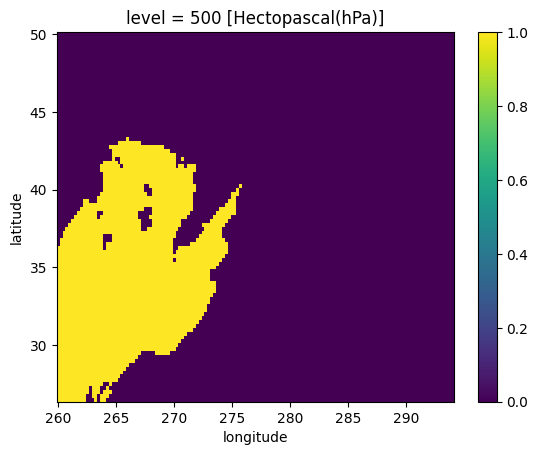

In [198]:
binary_predictions.plot()

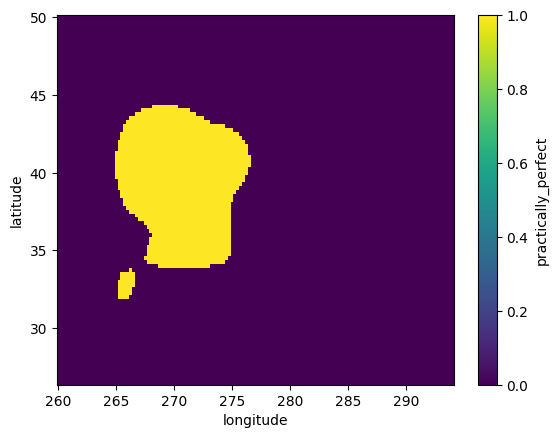

In [199]:
binary_targets.plot()

In [200]:

# Create contingency table
# True Positive: Both SIGSVR and PPH predict severe
true_positive = (binary_predictions * binary_targets).where(
        ~np.isnan(binary_predictions * binary_targets)
    )
# False Positive: PPH predicts severe but SIGSVR doesn't
false_positive = (binary_predictions * ~binary_targets).where(
        ~np.isnan(binary_predictions * binary_targets)
    )
# False Negative: SIGSVR predicts severe but PPH doesn't
false_negative =(~binary_predictions * binary_targets).where(
        ~np.isnan(binary_predictions * binary_targets)
    )
# True Negative: Neither predicts severe
true_negative = (~binary_predictions * ~binary_targets).where(
        ~np.isnan(binary_predictions * binary_targets)
    )


# Display contingency table
contingency_table = pd.DataFrame({
    'SIGSVR Yes': [true_positive.values.sum(), false_negative.values.sum()],
    'SIGSVR No': [false_positive.values.sum(), true_negative.values.sum()]
}, index=['PPH Yes', 'PPH No'])

print("Contingency Table:")
print(contingency_table)

# Calculate some verification metrics
total = true_positive.values.sum() + false_positive.values.sum() + false_negative.values.sum() + true_negative.values.sum()
accuracy = (true_positive.values.sum() + true_negative.values.sum()) / total
pod = true_positive.values.sum() / (true_positive.values.sum() + false_negative.values.sum())  # Probability of Detection
far = false_positive.values.sum() / (true_positive.values.sum() + false_positive.values.sum())  # False Alarm Ratio

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Probability of Detection (POD): {pod:.3f}")
print(f"False Alarm Ratio (FAR): {far:.3f}")

Contingency Table:
         SIGSVR Yes  SIGSVR No
PPH Yes       895.0     1687.0
PPH No        608.0     9825.0

Accuracy: 0.824
Probability of Detection (POD): 0.595
False Alarm Ratio (FAR): 0.653


In [190]:
895/(95*137)

0.06876680752977334

## MLWP

In [ ]:
models = ['PANG_v100_GFS','GRAP_v100_GFS']
dates = ['2023-03-31 18:00']
outputs = {}
for model, date in product(models, dates):
    if model == 'era5':
        outbreak = era5.sel(time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
        outbreak = outbreak.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                                    '10m_v_component_of_wind': 'surface_northward_wind',
                                    'u_component_of_wind': 'eastward_wind',
                                    'v_component_of_wind': 'northward_wind',
                                    'temperature': 'air_temperature',
                                    })
        outbreak = outbreak[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
        outbreak = outbreak.compute()
        outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(outbreak['level'] * metpy.units.units.hPa, outbreak['specific_humidity'] * metpy.units.units.dimensionless)
        craven_single = craven_sigsvr(outbreak)
        outputs[model][date] = craven_single
    else:
        basic_config = config.Config(
            forecast_dir=f'gs://extremeweatherbench/{model}.parq',
            event_types=['Severe']
        )
        model_ds = data_loader.open_kerchunk_reference(basic_config)
        model_ds = safe_rename(model_ds,{'u10': 'surface_eastward_wind',
                                    'v10': 'surface_northward_wind',
                                    'u': 'eastward_wind',
                                    'v': 'northward_wind',
                                    't': 'air_temperature',
                                    'r': 'relative_humidity',
                                    'q': 'specific_humidity',
                                    },return_renamed_only=True)
        outbreak = model_ds.sel(init_time=date,latitude=pph_orig_regridded.latitude[10:],longitude=pph_orig_regridded_longitude_360[100:], method='nearest')
        outbreak = outbreak.compute()
        if 'relative_humidity' in outbreak:
            outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_relative_humidity(outbreak['air_temperature'] * metpy.units.units.degC, outbreak['relative_humidity'] * metpy.units.units.percent)
        else:
            outbreak['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(outbreak['level'] * metpy.units.units.hPa, outbreak['specific_humidity'] * metpy.units.units.dimensionless)
        # Inverse the level dimension to match ERA5
        outbreak = outbreak.sortby('level', ascending=True)
        outbreak = outbreak.isel(time=0) # select hour 0
        print(model, outbreak.mean(['latitude','longitude']))
        # craven_single = craven_sigsvr(outbreak)
        # outputs[model][date] = craven_single


/home/taylor/code/ExtremeWeatherBench/.venv/lib/python3.11/site-packages/metpy/calc/thermo.py:1753: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


PANG_v100_GFS <xarray.Dataset> Size: 440B
Dimensions:                 (level: 13)
Coordinates:
    init_time               datetime64[ns] 8B 2023-03-31T18:00:00
  * level                   (level) float64 104B 50.0 100.0 ... 925.0 1e+03
    time                    datetime64[ns] 8B 2020-09-30
Data variables:
    surface_eastward_wind   float32 4B -0.06924
    surface_northward_wind  float32 4B 2.812
    eastward_wind           (level) float32 52B 8.105 27.95 ... 1.738 0.005673
    northward_wind          (level) float32 52B -2.629 -1.424 ... 5.954 3.453
    air_temperature         (level) float32 52B 211.0 211.4 ... 281.0 286.2
    specific_humidity       (level) float32 52B 1.713e-06 1.737e-06 ... 0.007056
    dewpoint_temperature    (level) float64 104B <Quantity([-91.84285309 -87....
GRAP_v100_GFS <xarray.Dataset> Size: 440B
Dimensions:                 (level: 13)
Coordinates:
    init_time               datetime64[ns] 8B 2023-03-31T18:00:00
  * level                   (level) float

/home/taylor/code/ExtremeWeatherBench/.venv/lib/python3.11/site-packages/metpy/calc/thermo.py:1753: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


In [56]:
# Save outputs to pickle file
import pickle
import os

# Save the outputs dictionary to a pickle file
output_file = '/home/taylor/data/craven_sigsvr_outputs_mlwp_era5.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(outputs, f)

print(f"Saved outputs to {output_file}")

Saved outputs to /home/taylor/data/craven_sigsvr_outputs_mlwp_era5.pkl


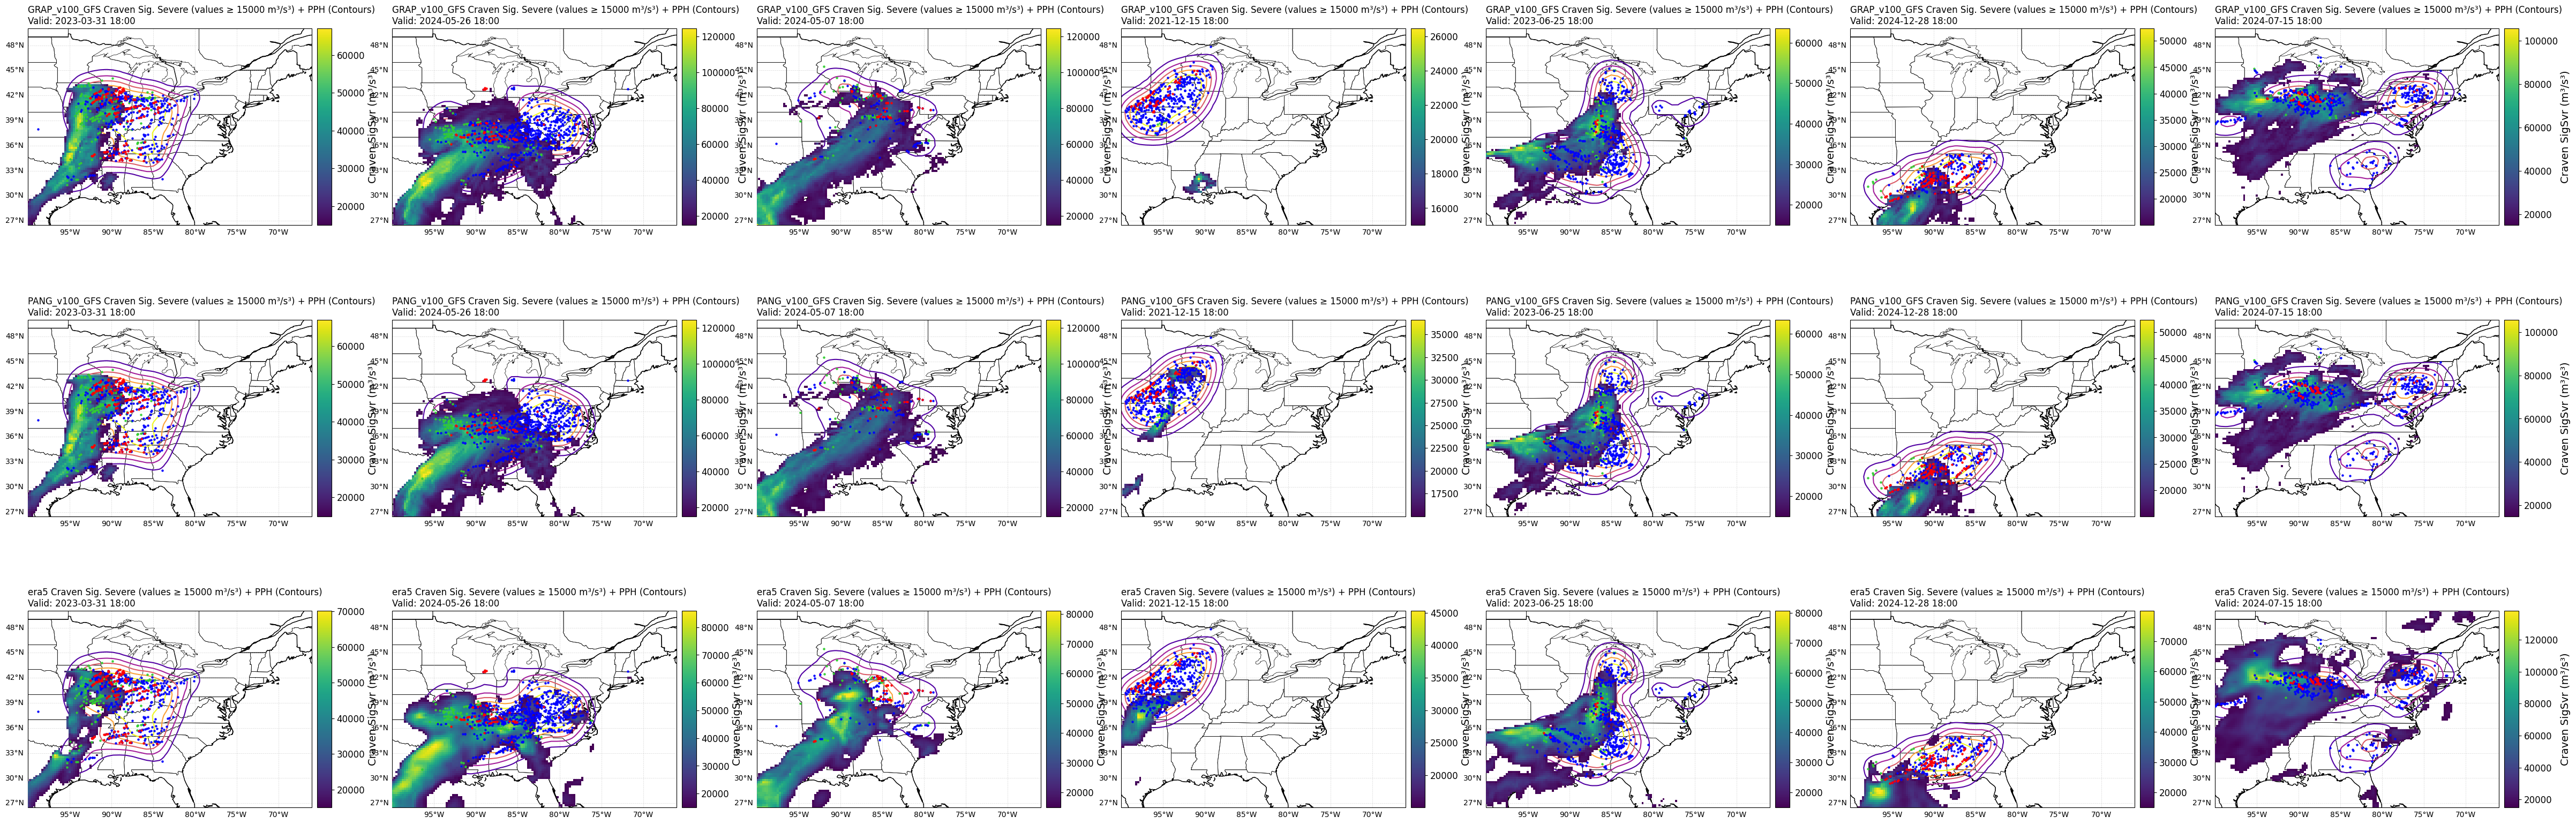

In [92]:
fig = plt.figure(figsize=(60, 20))
i = 0
for model, date in product(outputs, outputs[model]):
    i += 1
    pph, df = practically_perfect_hindcast(
        pd.to_datetime(date), 
        resolution=0.8, 
        output_resolution=0.25,
        return_reports=True  # match target grid spacing
    )
    value = outputs[model][date]
    # Create a figure with a map projection
    # Fix the KeyError by explicitly creating a GeoAxes with projection
    ax = fig.add_subplot(len(outputs), len(outputs[model]), i, projection=ccrs.PlateCarree())
    # Mask values below 5,000
    masked_sigsvr = value.where(value >= 15000)
    # Plot with aligned colorbar
    im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            add_colorbar=False,zorder=10)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
    cbar.set_label("Craven SigSvr (m³/s³)", size=14)
    cbar.ax.tick_params(labelsize=12)
    # ax.set_title(f'ERA5 Craven Significant Severe Parameter (values ≥ 20,000 m³/s³) + PPH (Contours) \nValid: {date_range[0].strftime("%Y-%m-%d %H:%MZ")} - {date_range[-1].strftime("%Y-%m-%d %H:%MZ")}',loc='left')
    ax.set_title(f'{model} Craven Sig. Severe (values ≥ 15000 m³/s³) + PPH (Contours) \nValid: {date}', loc='left')
    levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1
    # Create a custom colormap that sets alpha=0 for values below 0.05
    cmap = plt.cm.viridis
    norm = mcolors.BoundaryNorm(levels, cmap.N)
    # Create a mask for values below 0.05
    mask = np.ma.masked_less(pph, 0.05)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title('')
    ax.set_extent([value.longitude.min(), value.longitude.max(), 
                value.latitude.min(), value.latitude.max()], 
                crs=ccrs.PlateCarree())
    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.plasma.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

    contour = ax.contour(pph.longitude, pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        cmap=cmap_with_alpha, extend='both')

    # Plot the individual reports from the dataframe
    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}
    
    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['lon'].astype(float), group['lat'].astype(float), 
                color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                zorder=zorders.get(report_type, 10))
        

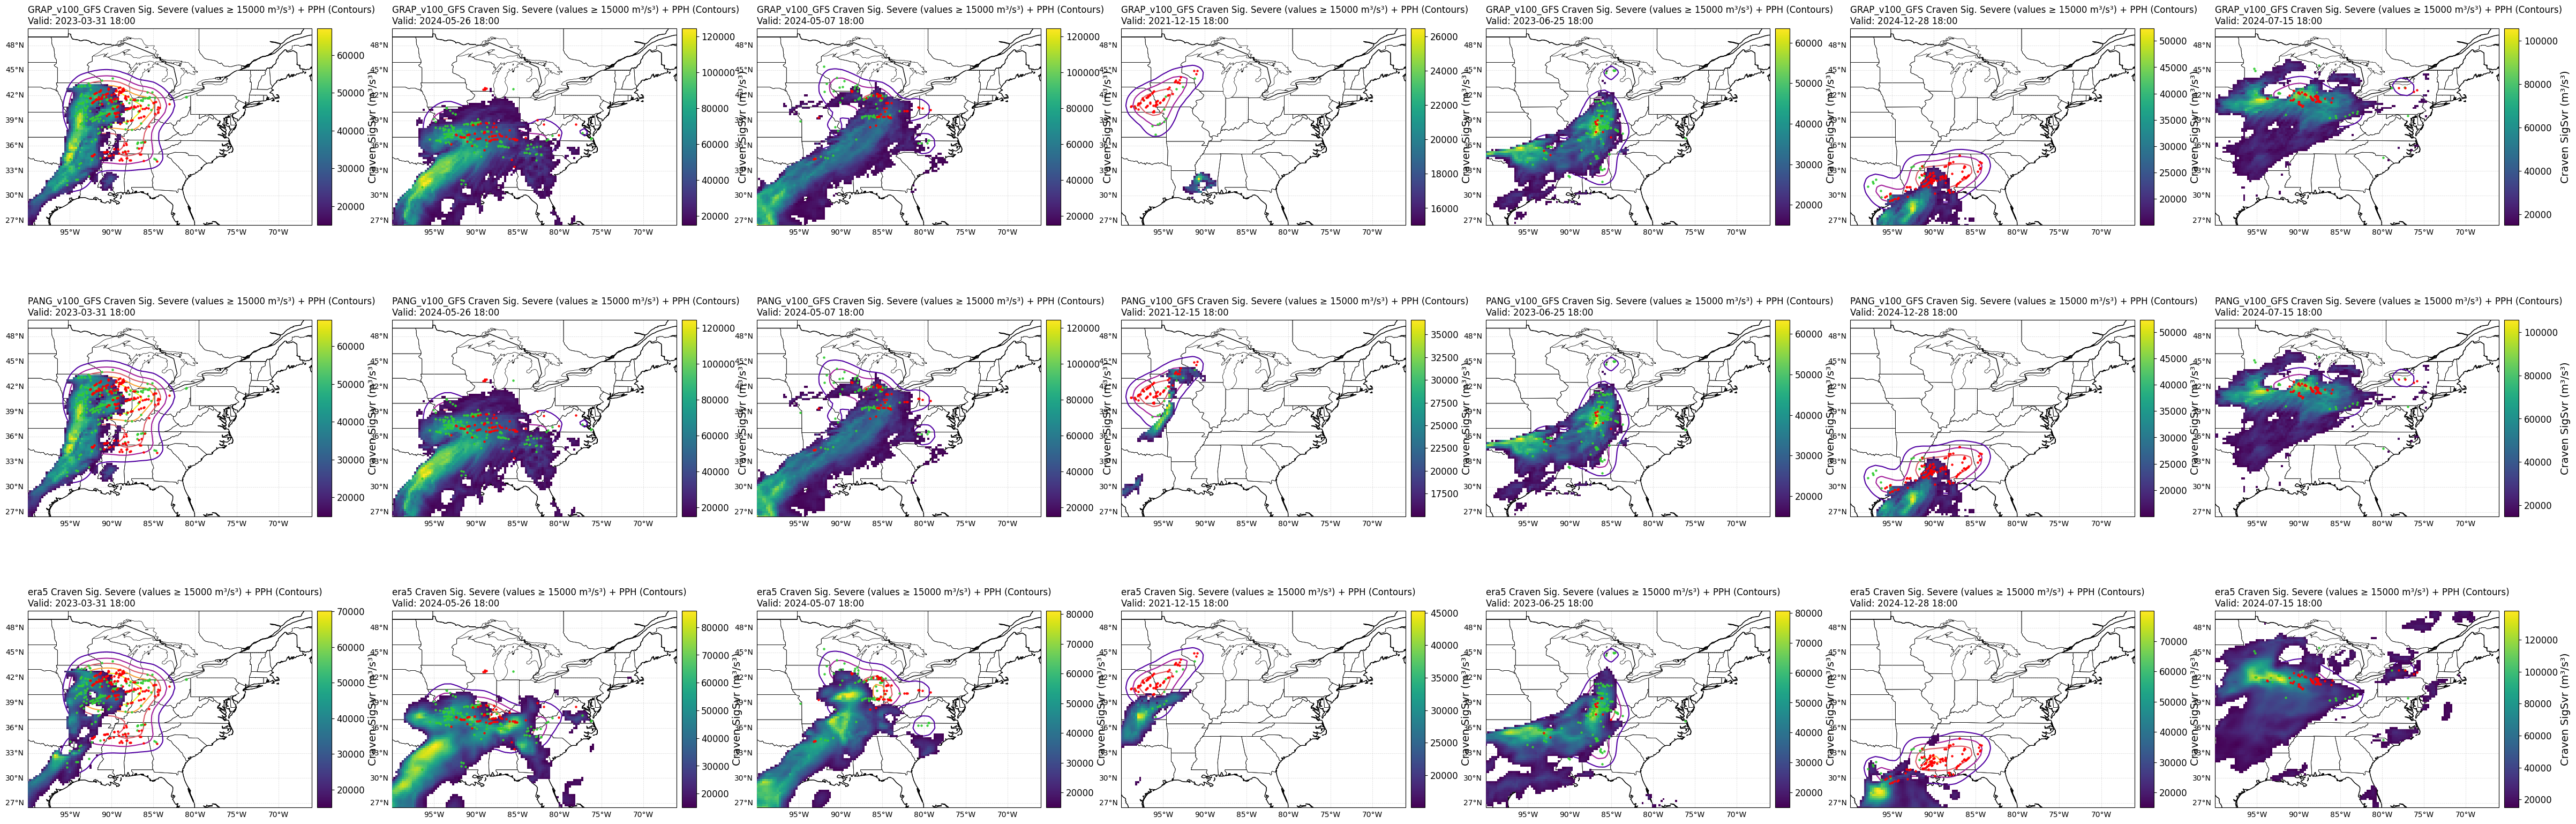

In [93]:
fig = plt.figure(figsize=(60, 20))
i = 0
for model, date in product(outputs, outputs[model]):
    i += 1
    pph, df = practically_perfect_hindcast(
        pd.to_datetime(date), 
        resolution=0.8, 
        output_resolution=0.25,
        return_reports=True,  # match target grid spacing
        report_type=["tor","hail"]
    )
    value = outputs[model][date]
    # Create a figure with a map projection
    # Fix the KeyError by explicitly creating a GeoAxes with projection
    ax = fig.add_subplot(len(outputs), len(outputs[model]), i, projection=ccrs.PlateCarree())
    # Mask values below 5,000
    masked_sigsvr = value.where(value >= 15000)
    # Plot with aligned colorbar
    im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis',
                            add_colorbar=False,zorder=10)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    cbar = fig.colorbar(im, cax=cax, label="Craven SigSvr (m³/s³)")
    cbar.set_label("Craven SigSvr (m³/s³)", size=14)
    cbar.ax.tick_params(labelsize=12)
    # ax.set_title(f'ERA5 Craven Significant Severe Parameter (values ≥ 20,000 m³/s³) + PPH (Contours) \nValid: {date_range[0].strftime("%Y-%m-%d %H:%MZ")} - {date_range[-1].strftime("%Y-%m-%d %H:%MZ")}',loc='left')
    ax.set_title(f'{model} Craven Sig. Severe (values ≥ 15000 m³/s³) + PPH (Contours) \nValid: {date}', loc='left')
    levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1
    # Create a custom colormap that sets alpha=0 for values below 0.05
    cmap = plt.cm.viridis
    norm = mcolors.BoundaryNorm(levels, cmap.N)
    # Create a mask for values below 0.05
    mask = np.ma.masked_less(pph, 0.05)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title('')
    ax.set_extent([value.longitude.min(), value.longitude.max(), 
                value.latitude.min(), value.latitude.max()], 
                crs=ccrs.PlateCarree())
    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.plasma.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

    contour = ax.contour(pph.longitude, pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        cmap=cmap_with_alpha, extend='both')

    # Plot the individual reports from the dataframe
    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}
    
    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['lon'].astype(float), group['lat'].astype(float), 
                color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                zorder=zorders.get(report_type, 10))
        

In [61]:
outputs['GRAP_v100_GFS'].keys()

dict_keys(['2023-03-31 18:00', '2024-05-26 18:00', '2024-05-07 18:00', '2021-12-15 18:00', '2023-06-25 18:00', '2024-12-28 18:00', '2024-07-15 18:00'])

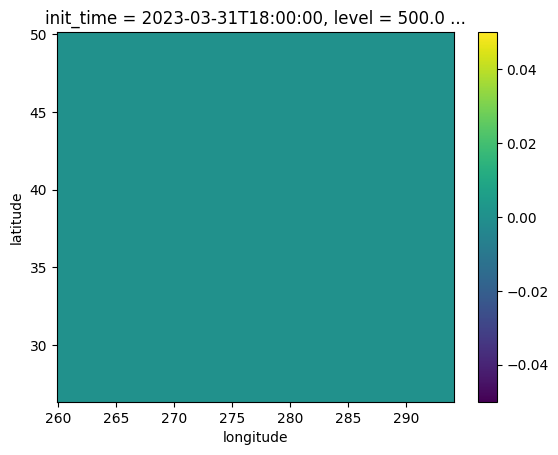

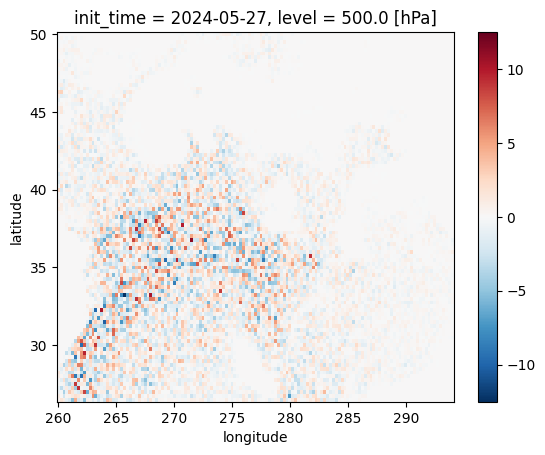

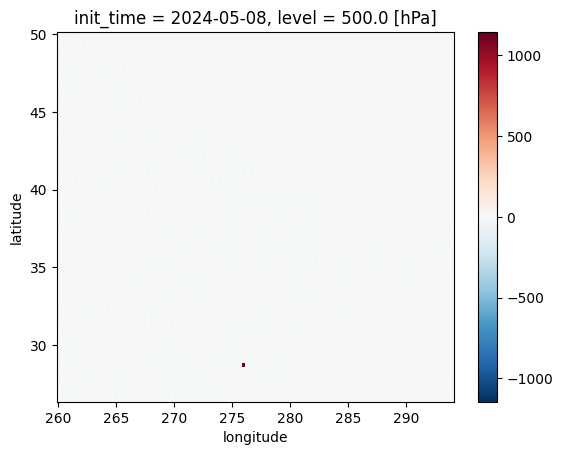

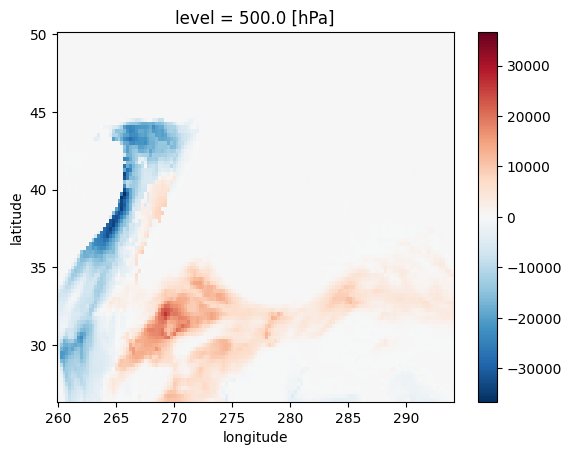

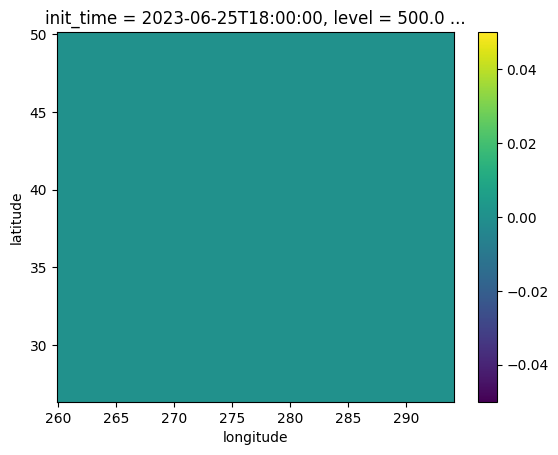

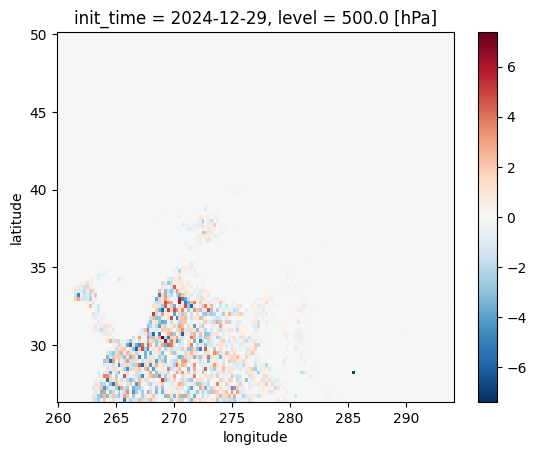

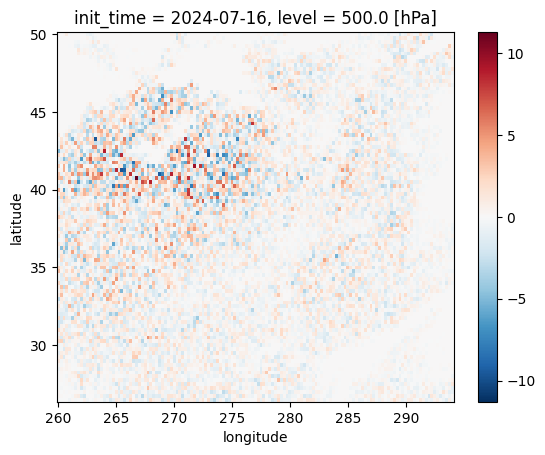

In [69]:
for key in outputs['GRAP_v100_GFS'].keys():
    (outputs['GRAP_v100_GFS'][key] - outputs['PANG_v100_GFS'][key]).plot()
    plt.show()

# Testing IOU

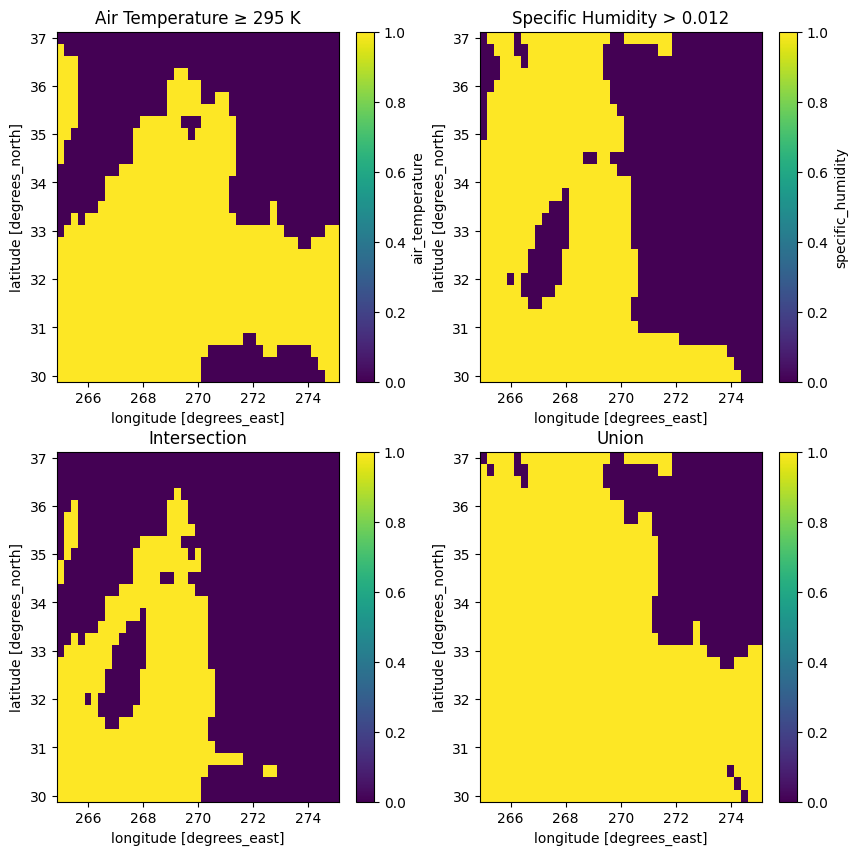

<xarray.DataArray ()> Size: 8B
array(0.42286349)
Coordinates:
    level    int64 8B 1000
    time     datetime64[ns] 8B 2023-03-31T18:00:00


In [47]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
(era5_outbreak['air_temperature'].isel(level=-1) >= 295).plot(ax=ax[0])
(era5_outbreak['specific_humidity'].isel(level=-1) > 0.012).plot(ax=ax[1])

intersect = (era5_outbreak['air_temperature'].isel(level=-1) >= 295) * (era5_outbreak['specific_humidity'].isel(level=-1) > 0.012)
intersect.plot(ax=ax[2])

union = (era5_outbreak['air_temperature'].isel(level=-1) >= 295) + (era5_outbreak['specific_humidity'].isel(level=-1) > 0.012)
union.plot(ax=ax[3])

ax[0].set_title('Air Temperature ≥ 295 K')
ax[1].set_title('Specific Humidity > 0.012')
ax[2].set_title('Intersection')
ax[3].set_title('Union')
plt.show()

print(intersect.sum() / union.sum())

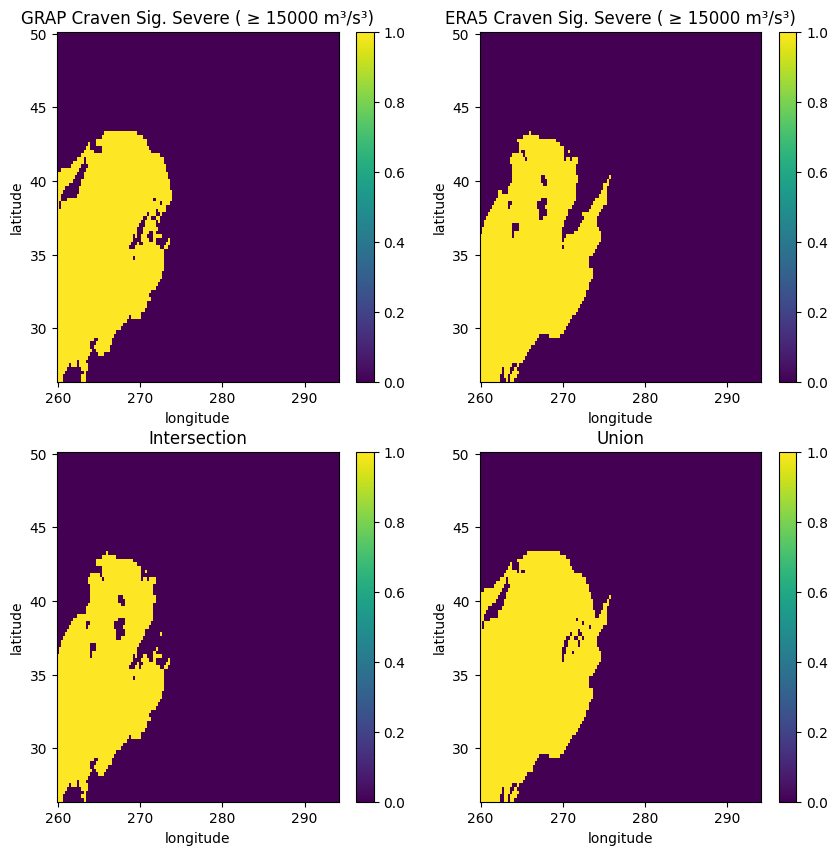

<xarray.DataArray ()> Size: 8B
array(0.75456389)
Coordinates:
    level    float64 8B 500.0


In [55]:
import pickle

# Load the pickle file
with open('/home/taylor/data/max_grap_craven_2023033018_2023040106.pkl', 'rb') as f:
    grap_cbss = pickle.load(f)
    
with open('/home/taylor/data/max_era5_craven_2023033018_2023040106.pkl', 'rb') as f:
    era5_cbss = pickle.load(f)

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
(grap_cbss >= 15000).plot(ax=ax[0])
(era5_cbss >= 15000).plot(ax=ax[1])

intersect = (grap_cbss >= 15000) * (era5_cbss >= 15000)
intersect.plot(ax=ax[2])

union = (grap_cbss >= 15000) + (era5_cbss >= 15000)
union.plot(ax=ax[3])

ax[0].set_title('GRAP Craven Sig. Severe ( ≥ 15000 m³/s³)')
ax[1].set_title('ERA5 Craven Sig. Severe ( ≥ 15000 m³/s³)')
ax[2].set_title('Intersection')
ax[3].set_title('Union')
plt.show()
print(intersect.sum() / union.sum())

In [59]:
# Import necessary libraries if not already imported
import numpy as np
import pandas as pd

# Get the practically perfect hindcast for the same date as the Craven data
pph, df = practically_perfect_hindcast(
    pd.to_datetime('2023-03-31 18:00'), 
    resolution=0.8, 
    output_resolution=0.25,
    return_reports=True,
    report_type=["tor","hail"]
)

# Adjust longitude to match the same coordinate system as grap_cbss
pph['longitude'] = pph['longitude'] + 360

# Align pph to the same grid as grap_cbss
# First, create a template with the same coordinates as grap_cbss
aligned_pph = grap_cbss.copy() * 0

# Use xarray's interp method to interpolate pph onto grap_cbss grid
# This assumes pph and grap_cbss have compatible coordinate systems
aligned_pph = pph.interp_like(grap_cbss, method='nearest')

aligned_pph


<xarray.DataArray 'practically_perfect' (latitude: 95, longitude: 137)> Size: 104kB
array([[7.07907173e-08, 1.34994740e-07, 1.99198764e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.75506264e-07, 3.34770033e-07, 4.94033803e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.80221810e-07, 5.34545326e-07, 7.88868843e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(95, 137))
Coordinates:
  * latitude   (latitude) float32 380B 26.5 26.75 27.0 27.25 ... 49.5 49.75 50.0
  * longitude  (longitude) float32 548B 260.0 260.2 260.5 ... 293.5 293.8 294.0

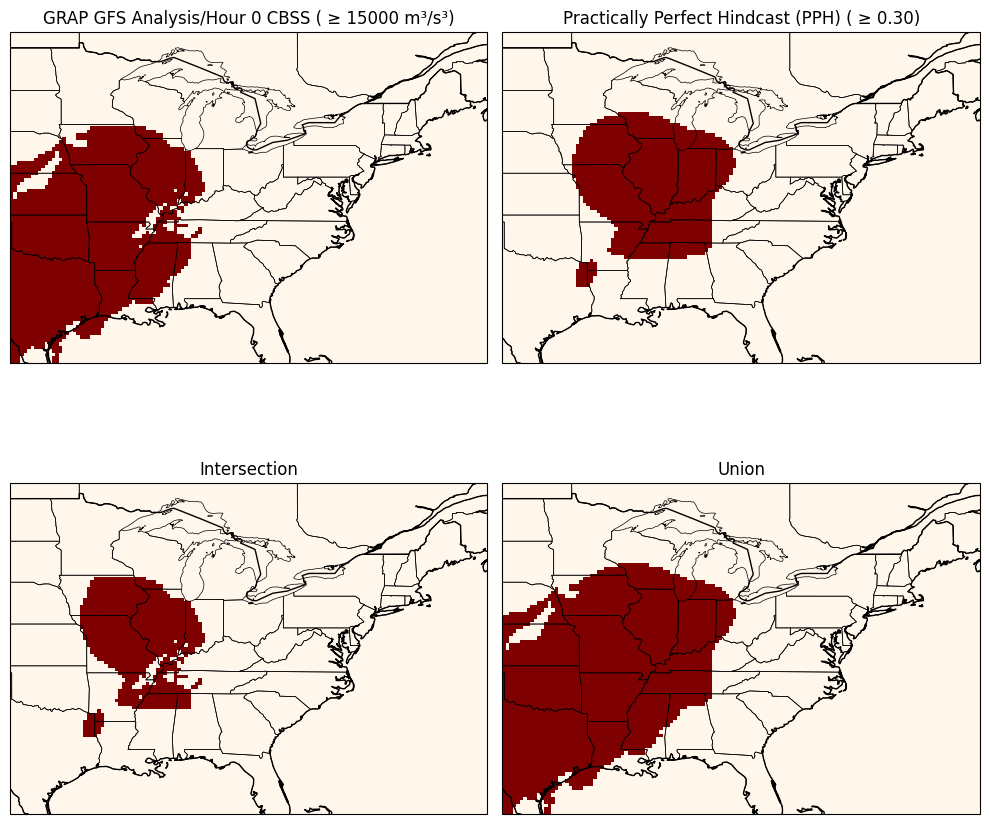

0.3088188475007959


In [76]:
fig, ax = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()
(grap_cbss >= 15000).plot(ax=ax[0],cmap='OrRd',add_colorbar=False)
(aligned_pph >= 0.30).plot(ax=ax[1],cmap='OrRd',add_colorbar=False)

intersect = (grap_cbss >= 15000) * (aligned_pph >= 0.30)
intersect.plot(ax=ax[2],cmap='OrRd',add_colorbar=False)

union = (grap_cbss >= 15000) + (aligned_pph >= 0.30)
union.plot(ax=ax[3],cmap='OrRd',add_colorbar=False)

ax[0].set_title('GRAP GFS Analysis/Hour 0 CBSS ( ≥ 15000 m³/s³)')
ax[1].set_title('Practically Perfect Hindcast (PPH) ( ≥ 0.30)')
ax[2].set_title('Intersection')
ax[3].set_title('Union')
for axs in ax:
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.STATES, linewidth=0.5)
    axs.add_feature(cfeature.BORDERS)
    # Set purple color (False values) to be transparent
plt.tight_layout()
plt.show()
print((intersect.sum() / union.sum()).values)

In [ ]:
predictions = (era5_outbreak['air_temperature'].isel(level=-1) >= 290).where(~np.isnan(era5_outbreak['air_temperature']))
targets = (era5_outbreak >= 0.30).where(~np.isnan(era5_outbreak))


# Convert to binary masks
binary_predictions = predictions.astype(bool)
binary_targets = targets.astype(bool)

print("Aligned predictions shape:", predictions.shape)
print("Aligned targets shape:", targets.shape)


In [7]:
# this is a hack to see if Australia LSRs can be made to work for our purposes

def extract_lsr_data_australia(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    # LOCAL FILE HACK
    aus_file = '/home/amy/AustralianLSRData_2020-2024.csv'

    # Read the CSV files with all columns to identify report types
    try:
        df = pd.read_csv(aus_file, delimiter=',', engine='python', parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()
    if len(df) == 3:
        return pd.DataFrame()

    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        print(f'No LSR data found for {date}')
        return pd.DataFrame()
    return df


In [5]:
aus_date = pd.Timestamp(2020,10,31,18,00)
aus_data = extract_lsr_data_australia(aus_date)

In [11]:
# fix the broken datetimes in the australian hail data
hail_file = '/home/amy/AustralianHailData_2020-2024_cleaned.csv'
df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
df_hail = df_hail[['UTC', 'Latitude', 'Longitude', 'Nearest town', 'State', "Hail size"]]

# rename the date column to match the tornado data
df_hail.rename(columns={'UTC': 'Date/Time UTC'}, inplace=True)

# Crate a report_type column
df_hail['report_type'] = 'hail'

# save the new file
new_hail_file = '/home/amy/AustralianHailData_2020-2024_cleaned_fixed.csv'
df_hail.to_csv(new_hail_file, index=False)

# fix the broken date-times in the tornado data
tor_file = '/home/amy/AustralianTornadoData_2020-2024_cleaned.csv'
df_tor = pd.read_csv(tor_file, delimiter=',', engine='python', parse_dates=['Date/Time UTC'], infer_datetime_format=True)
df_tor = df_tor[['Date/Time UTC', 'Latitude', 'Longitude', 'Nearest town', 'State', "Fujita scale"]]

# Crate a report_type column
df_tor['report_type'] = 'tor'

# save the new file
new_tor_file = '/home/amy/AustralianTornadoData_2020-2024_cleaned_fixed.csv'
df_tor.to_csv(new_tor_file, index=False)

# create a combined file for sharing
df_combined = pd.concat([df_hail, df_tor], ignore_index=True)
combined_file = '/home/amy/AustralianLSRData_2020-2024.csv'

# save the combined file
df_combined.to_csv(combined_file, index=False)

print ("DONE")

DONE


/tmp/ipykernel_2847/2188099264.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
/tmp/ipykernel_2847/2188099264.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_hail = pd.read_csv(hail_file, delimiter=',', engine='python', parse_dates=['UTC'], infer_datetime_format=True)
/tmp/ipykernel_2847/2188099264.py:18: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-da

In [25]:
# imported from figure 1 notebook and adjusted to plot reports
def plot_local_cases(left_lon, right_lon, bot_lat, top_lat, df, pph, filename, plot_title):
    fig = plt.figure(figsize=(15, 10))
    #ax = plt.axes(projection=ccrs.LambertConformal())
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    my_box = [left_lon, right_lon, bot_lat, top_lat]
    ax.set_extent(my_box, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

     # Plot the data using contourf
    levels = [.05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1

    # Create a custom colormap that sets alpha=0 for values below 0.05
    cmap = plt.cm.viridis
    norm = mcolors.BoundaryNorm(levels, cmap.N)

    # Create a mask for values below 0.05
    mask = np.ma.masked_less(pph, 0.05)

    # Create the colormap with alpha=0 for values below 0.05
    cmap_with_alpha = plt.cm.viridis.copy()
    cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

    contour = ax.contourf(pph.longitude, pph.latitude, mask, 
                        levels=levels, transform=ccrs.PlateCarree(),
                        cmap=cmap_with_alpha, extend='both')

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Probability')

    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'limegreen'}

    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['Longitude'].astype(float), group['Latitude'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker='.', alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))

    # Count the number of reports for each type
    counts = df['report_type'].value_counts().to_dict()
    print(counts)

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker='o', color=colors[label], label=f'{label} (n={count})', markerfacecolor=colors[label], markersize=10)
        for label, count in counts.items()
    ]
    
     # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    ax.set_title(plot_title, loc='left', fontsize=20)
    plt.savefig(filename, transparent=True)

{'tor': 77, 'hail': 70}


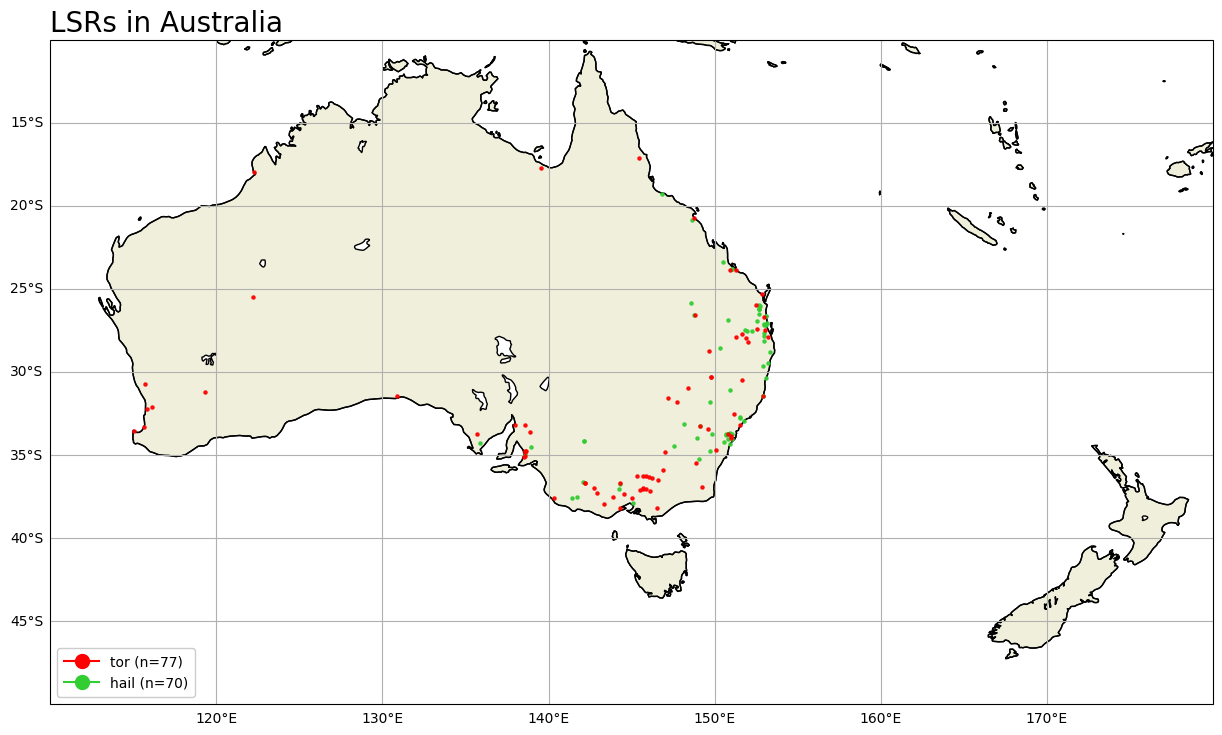

In [ ]:
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 180
filename = 'Australia_LSR.png'
plot_title = 'LSRs in Australia'

aus_data = extract_lsr_data_australia(date=None)  # Get all reports

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, aus_data, filename, plot_title)
    

2020-05-31: 3 reports - {'tor': 3}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.1563786)
{'tor': 3}
2021-09-30: 6 reports - {'hail': 4, 'tor': 2}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.25623734)
{'hail': 4, 'tor': 2}
2021-10-14: 6 reports - {'hail': 4, 'tor': 2}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.30034969)
{'hail': 4, 'tor': 2}
2021-10-18: 4 reports - {'hail': 3, 'tor': 1}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.18911022)
{'hail': 3, 'tor': 1}
2021-10-28: 4 reports - {'hail': 2, 'tor': 2}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.1874048)
{'hail': 2, 'tor': 2}
2024-08-25: 12 reports - {'tor': 11, 'hail': 1}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.87861166)
{'tor': 11, 'hail': 1}
2024-10-09: 3 reports - {'hail': 3}
<xarray.DataArray 'practically_perfect' ()> Size: 8B
array(0.12945742)
{'hail': 3}
2024-11-13: 3 reports - {'hail': 3}
<xarray.DataArray 'practically_p

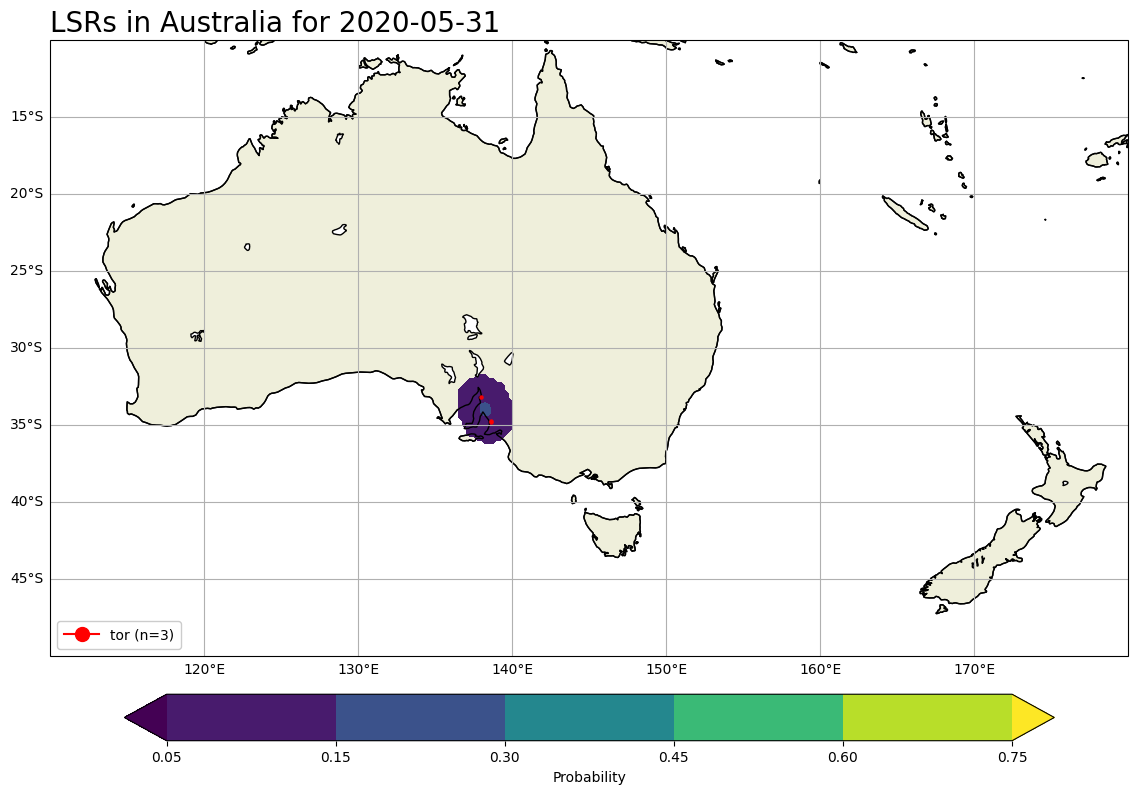

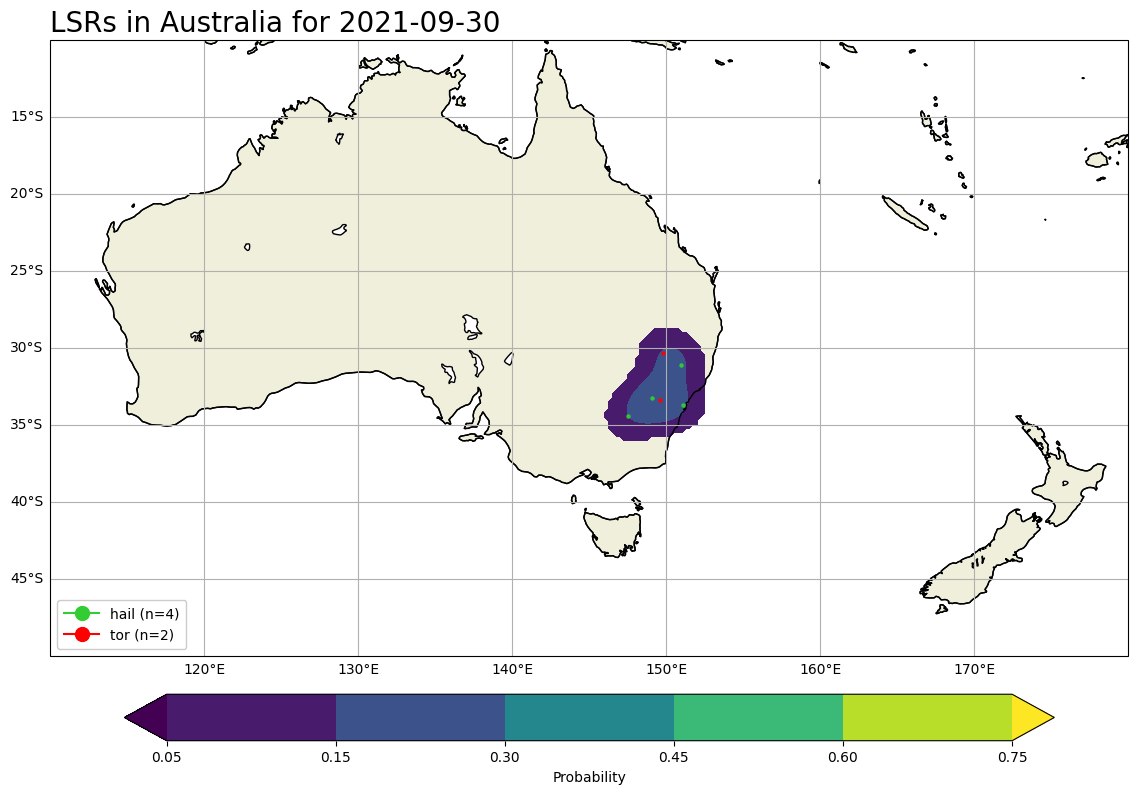

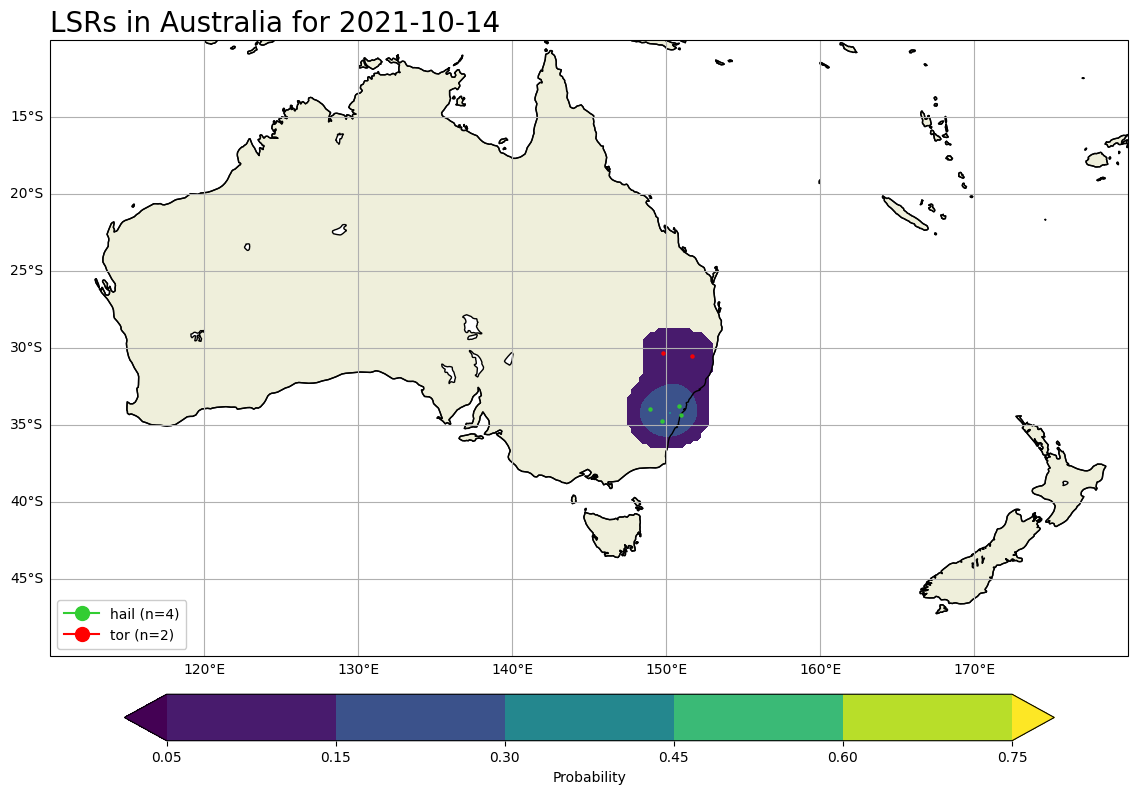

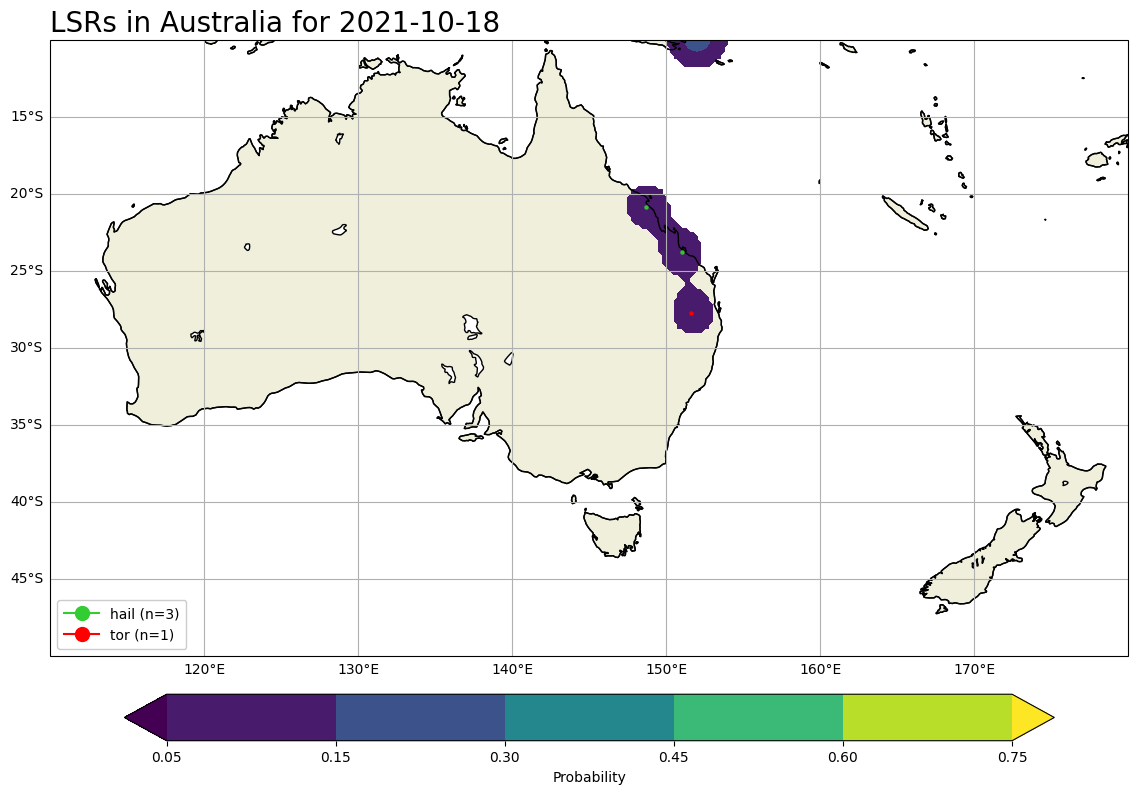

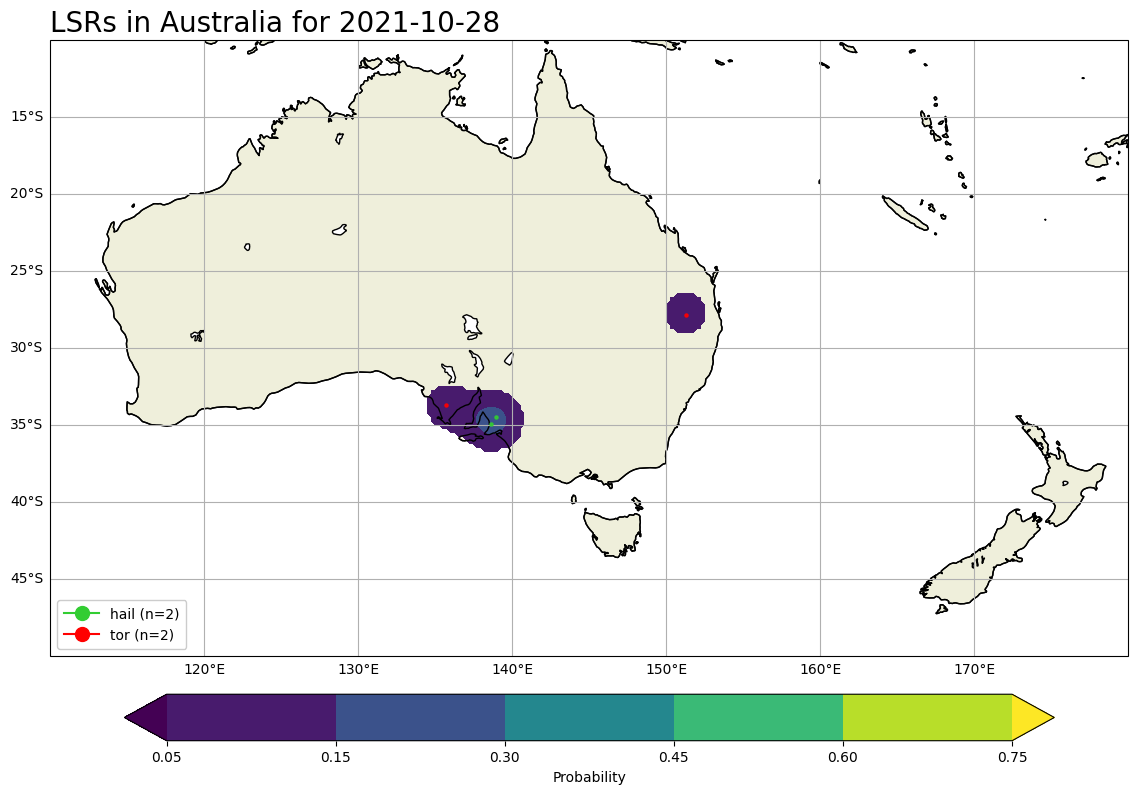

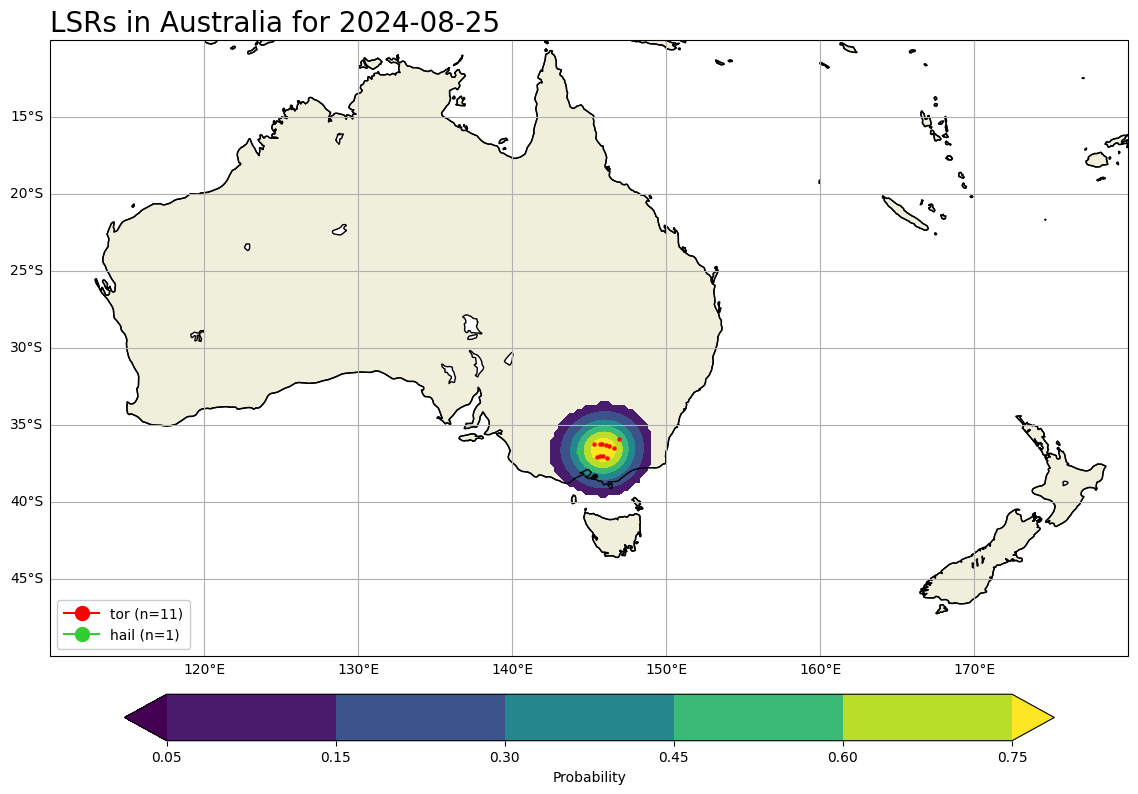

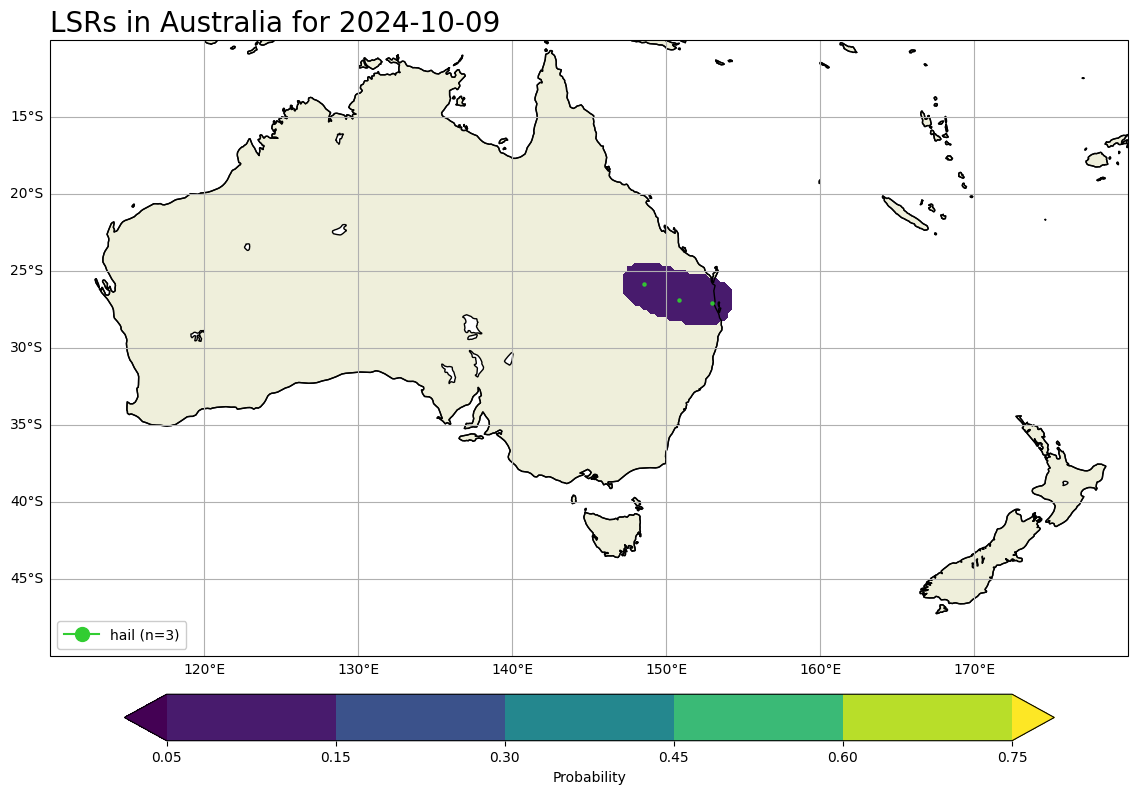

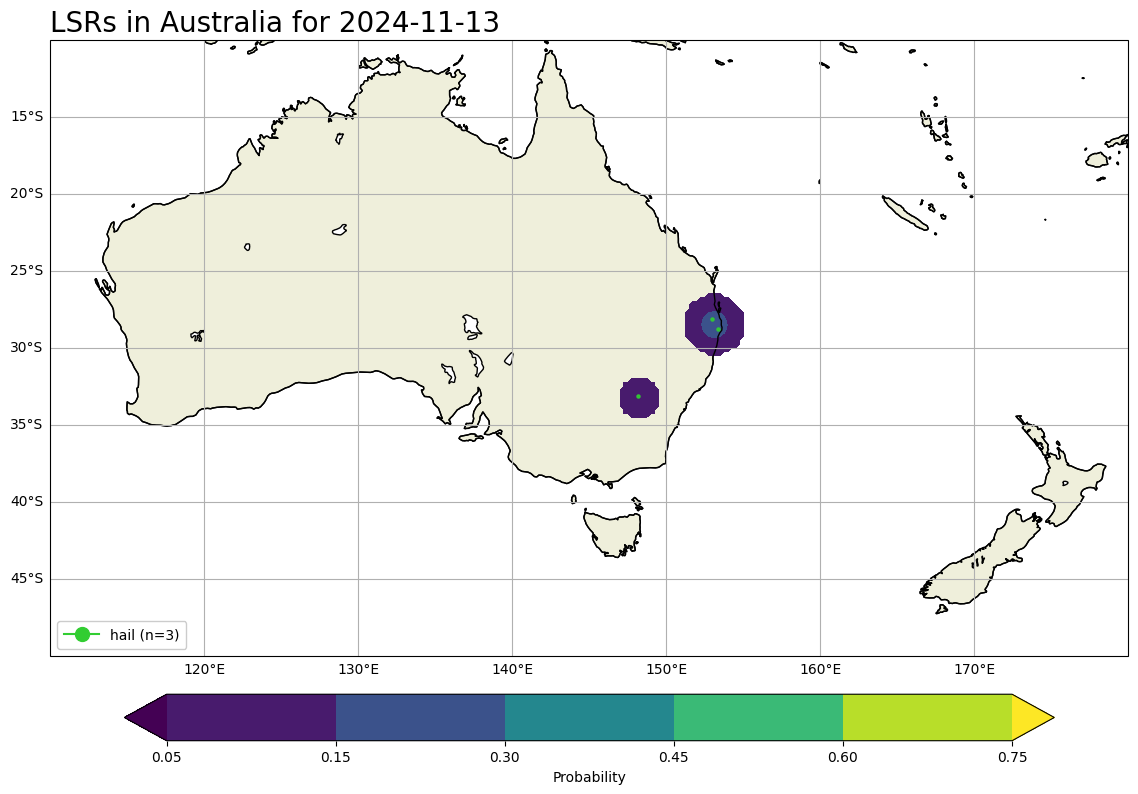

In [50]:
# look through every date in the australia data print the case count for all non-zero dates
aus_data = extract_lsr_data_australia(date=None)  # Get all reports

# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
     # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
    if len(daily_data) > 2:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

        filename = f"Australia_LSR_{date.strftime('%Y-%m-%d')}.png"
        plot_title = f"LSRs in Australia for {date.strftime('%Y-%m-%d')}"

        # compute PPH on this date
        pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constant=15)
        print(pph_aus.max())

        # plot PPH and the cases
        plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, pph_aus, filename, plot_title)
        

In [42]:
def practically_perfect_hindcast_aus(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constant = 10,
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = extract_lsr_data_australia(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Extract latitude and longitude from the dataframe
    lats = df["Latitude"].astype(float)
    lons = df["Longitude"].astype(float)

    # Create a grid covering Australia
    lat_min, lat_max = -50, -10.0   
    lon_min, lon_max = 110, 180  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # Mark grid cells that contain reports
    for lat, lon in zip(lats, lons):
        # Find the nearest grid indices
        lat_idx = np.abs(grid_lats - lat).argmin()
        lon_idx = np.abs(grid_lons - lon).argmin()
        grid[lat_idx, lon_idx] = report_constant  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
    if return_reports:
        return (pph, df)
    return pph

<xarray.DataArray 'practically_perfect' (latitude: 161, longitude: 281)> Size: 362kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(161, 281))
Coordinates:
  * latitude   (latitude) float64 1kB -50.0 -49.75 -49.5 ... -10.5 -10.25 -10.0
  * longitude  (longitude) float64 2kB 110.0 110.2 110.5 ... 179.5 179.8 180.0


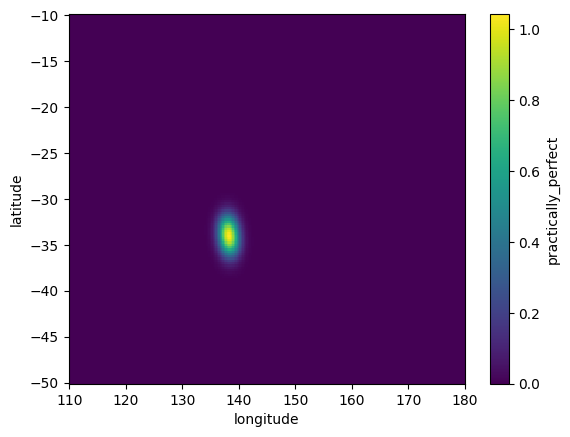

In [46]:
big_aus_date = pd.Timestamp(2020,5,31,00,00)
pph_aus = practically_perfect_hindcast_aus(big_aus_date, sigma=5, report_constant=100)
print(pph_aus)
pph_aus.plot()